# Composer Classification with Deep Learning

## Setup

### Installs

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=7d2956aed3996133ed5a4f029ddb581766baf64dea6413e9fac03009e6538841
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [3]:
!pip install pretty_midi mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 95.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=94d9754bd2c81bc898ba78bca5db0388fefebbc36d64b25a925095a552e5f179
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [4]:
!pip install pypianoroll

### Import modules

In [259]:
import collections
import datetime
import fluidsynth
import glob
import os
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import mido
import pypianoroll
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from IPython import display as ipydisplay
from typing import Optional
from nltk.probability import FreqDist
from itertools import chain
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Download dataset from github

In [6]:
 # Download dataset from github
!wget https://github.com/julietlawton/composer-classification/raw/main/composers.zip

--2024-08-10 03:24:51--  https://github.com/julietlawton/composer-classification/raw/main/composers.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/julietlawton/composer-classification/main/composers.zip [following]
--2024-08-10 03:24:51--  https://media.githubusercontent.com/media/julietlawton/composer-classification/main/composers.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13436472 (13M) [application/zip]
Saving to: ‘composers.zip’

composers.zip       100%[===================>]  12.81M  --.-KB/s    in 0.03s   

2024-08-10 03:24:53 (426 MB/s) - ‘composers.zip’ 

In [7]:
# Unzip the compressed dataset
!unzip composers.zip

Archive:  composers.zip
   creating: composers/
   creating: composers/Mozart/
  inflating: __MACOSX/composers/._Mozart  
   creating: composers/Chopin/
  inflating: __MACOSX/composers/._Chopin  
  inflating: composers/.DS_Store     
  inflating: __MACOSX/composers/._.DS_Store  
   creating: composers/Beethoven/
  inflating: __MACOSX/composers/._Beethoven  
   creating: composers/Bach/
  inflating: __MACOSX/composers/._Bach  
  inflating: composers/Mozart/Symphony n22 K162 1mov.mid  
  inflating: __MACOSX/composers/Mozart/._Symphony n22 K162 1mov.mid  
  inflating: composers/Mozart/Symphony n37 K444 1mov.mid  
  inflating: __MACOSX/composers/Mozart/._Symphony n37 K444 1mov.mid  
  inflating: composers/Mozart/K495 Horn Concerto n4 1mov.mid  
  inflating: __MACOSX/composers/Mozart/._K495 Horn Concerto n4 1mov.mid  
  inflating: composers/Mozart/K626 Requiem 05 Recordare.mid  
  inflating: __MACOSX/composers/Mozart/._K626 Requiem 05 Recordare.mid  
  inflating: composers/Mozart/K492 Overt

## Feature Extraction

### Load songs

In [718]:
# Set the path to the composers directory
composers_dir = '/content/composers/'

# List the composers that will be used for classification
composers = next(os.walk(composers_dir))[1]

# Create objects to store each song and its composer
songs = []
labels = []

# Get each composer/song pair
for composer in composers:
  root = composers_dir+composer
  for file in os.listdir(root):
    if '.mid' in file:
      path = os.path.join(root, file)
      songs.append(path)
      labels.append(composer)

# Create a dataframe to store all the songs and use with feature extraction
composers_df = pd.DataFrame({'song': songs, 'composer': labels})

In [719]:
# Check the first 5 entries
composers_df.head()

song   composer
0  /content/composers/Beethoven/Symphony n2 op36 ...  Beethoven
1  /content/composers/Beethoven/Piano Sonata n06.mid  Beethoven
2  /content/composers/Beethoven/Piano Sonata n29 ...  Beethoven
3  /content/composers/Beethoven/Rondo Opus.51, No...  Beethoven
4  /content/composers/Beethoven/Overture ''Leonor...  Beethoven

Total number of songs: 1531


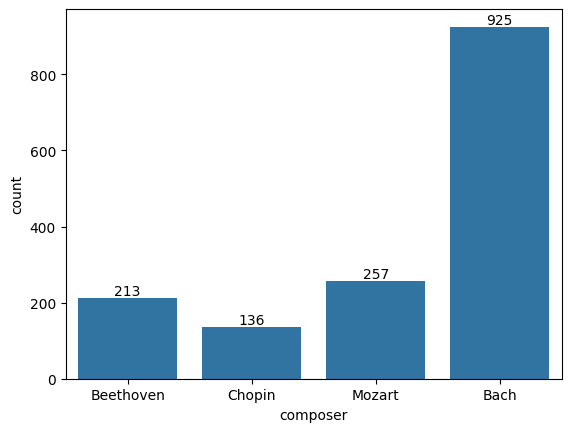

In [720]:
# Print total number of songs
print(f'Total number of songs: {len(composers_df)}')

# Plot the song counts for each composer
ax = sns.countplot(data=composers_df, x='composer')
ax.bar_label(ax.containers[0])
plt.show()

### Downsampling

Total number of songs after downsampling: 1120


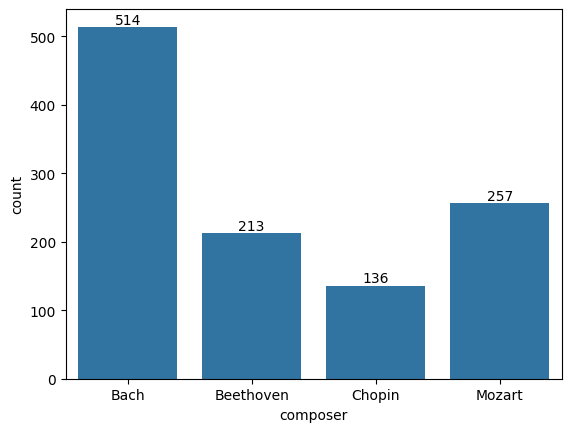

In [721]:
# Downsample Bach songs to address class imbalance
bach_songs = composers_df[composers_df['composer'] == 'Bach']
n_samples = len(composers_df[composers_df['composer'] == 'Mozart'])*2

bach_downsample = resample(
    bach_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

non_bach_songs = composers_df[composers_df['composer'] != 'Bach']
composers_df = pd.concat([bach_downsample, non_bach_songs])

# Print total number of songs
print(f'Total number of songs after downsampling: {len(composers_df)}')

# Plot the song counts for each composer
ax = sns.countplot(data=composers_df, x='composer')
ax.bar_label(ax.containers[0])
plt.show()

### Upsampling

Total number of songs after upsampling: 1240


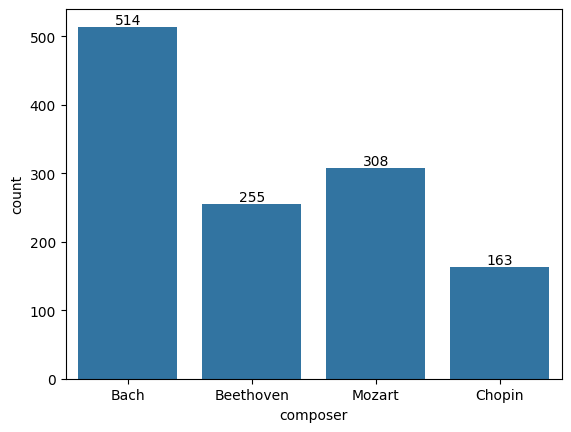

In [722]:
# Upsample non-Bach songs to address class imbalance
beethoven_songs = composers_df[composers_df['composer'] == 'Beethoven']
n_samples = int(len(composers_df[composers_df['composer'] == 'Beethoven'])*1.2)

beethoven_upsample = resample(
    beethoven_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

mozart_songs = composers_df[composers_df['composer'] == 'Mozart']
n_samples = int(len(composers_df[composers_df['composer'] == 'Mozart'])*1.2)

mozart_upsample = resample(
    mozart_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

chopin_songs = composers_df[composers_df['composer'] == 'Chopin']
n_samples = int(len(composers_df[composers_df['composer'] == 'Chopin'])*1.2)

chopin_upsample = resample(
    chopin_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

bach_songs = composers_df[composers_df['composer'] == 'Bach']
composers_df = pd.concat([
    bach_songs,
    beethoven_upsample,
    mozart_upsample,
    chopin_upsample
])

# Print total number of songs
print(f'Total number of songs after upsampling: {len(composers_df)}')

# Plot the song counts for each composer
ax = sns.countplot(data=composers_df, x='composer')
ax.bar_label(ax.containers[0])
plt.show()

### Visualize songs

In [12]:
# Define a method for playing a snippet of a song
# SOURCE: https://www.tensorflow.org/tutorials/audio/music_generation#process_a_midi_file
sampling_rate = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=sampling_rate)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*sampling_rate]
  return ipydisplay.Audio(waveform_short, rate=sampling_rate)

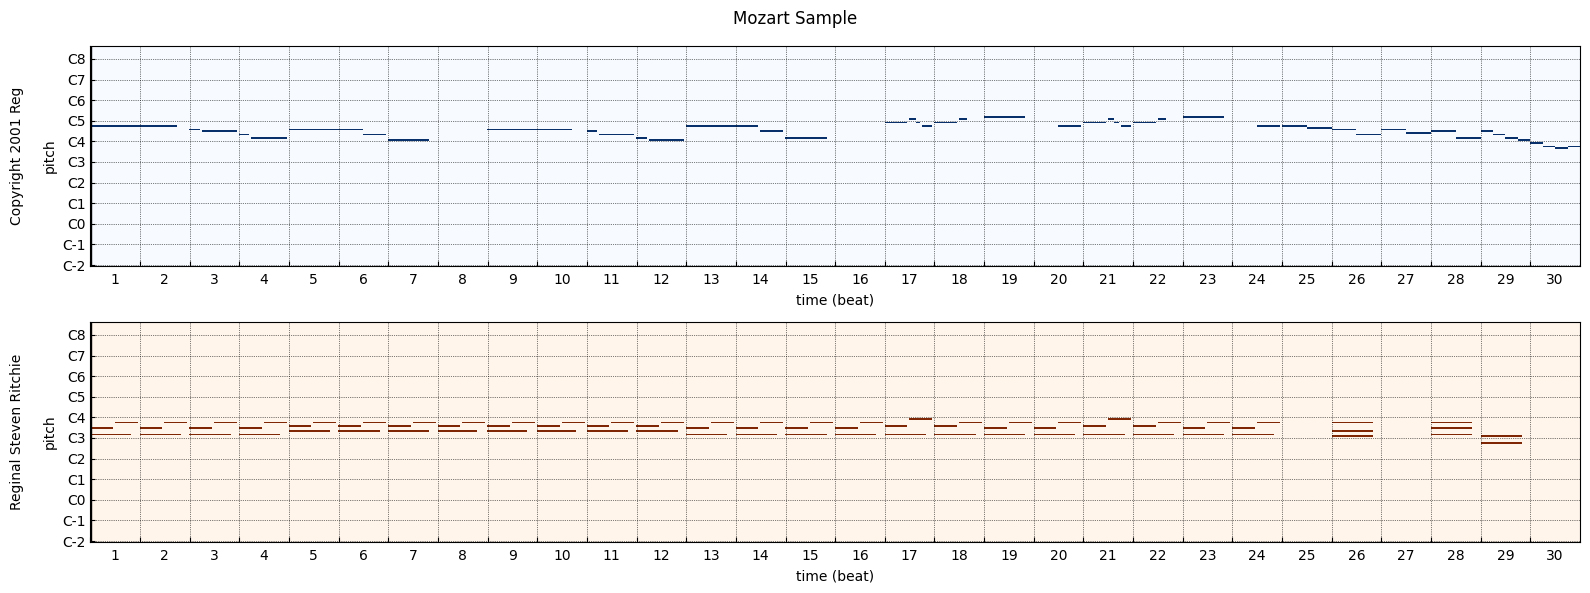

In [13]:
# Load a sample of a song by each composer and plot the piano roll
mozart_sample_file = composers_df['song'][composers_df['composer'] == 'Mozart'].iloc[1]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(mozart_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 6))
multitrack.plot(axs=axs)
fig.suptitle('Mozart Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
mozart_pm = pretty_midi.PrettyMIDI(mozart_sample_file)
display_audio(mozart_pm)



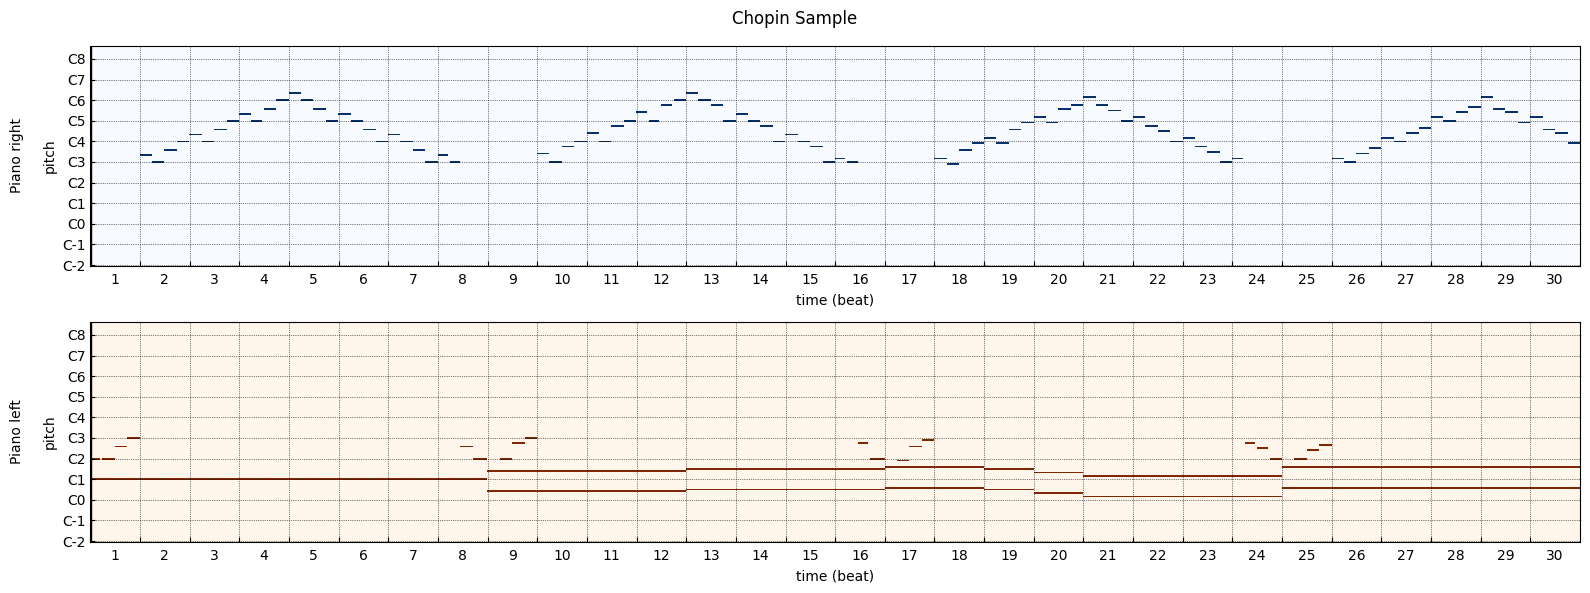

In [14]:
# Load a sample of a song by each composer and plot the piano roll
chopin_sample_file = composers_df['song'][composers_df['composer'] == 'Chopin'].iloc[1]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(chopin_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 6))
multitrack.plot(axs=axs)
fig.suptitle('Chopin Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
chopin_pm = pretty_midi.PrettyMIDI(chopin_sample_file)
display_audio(chopin_pm)


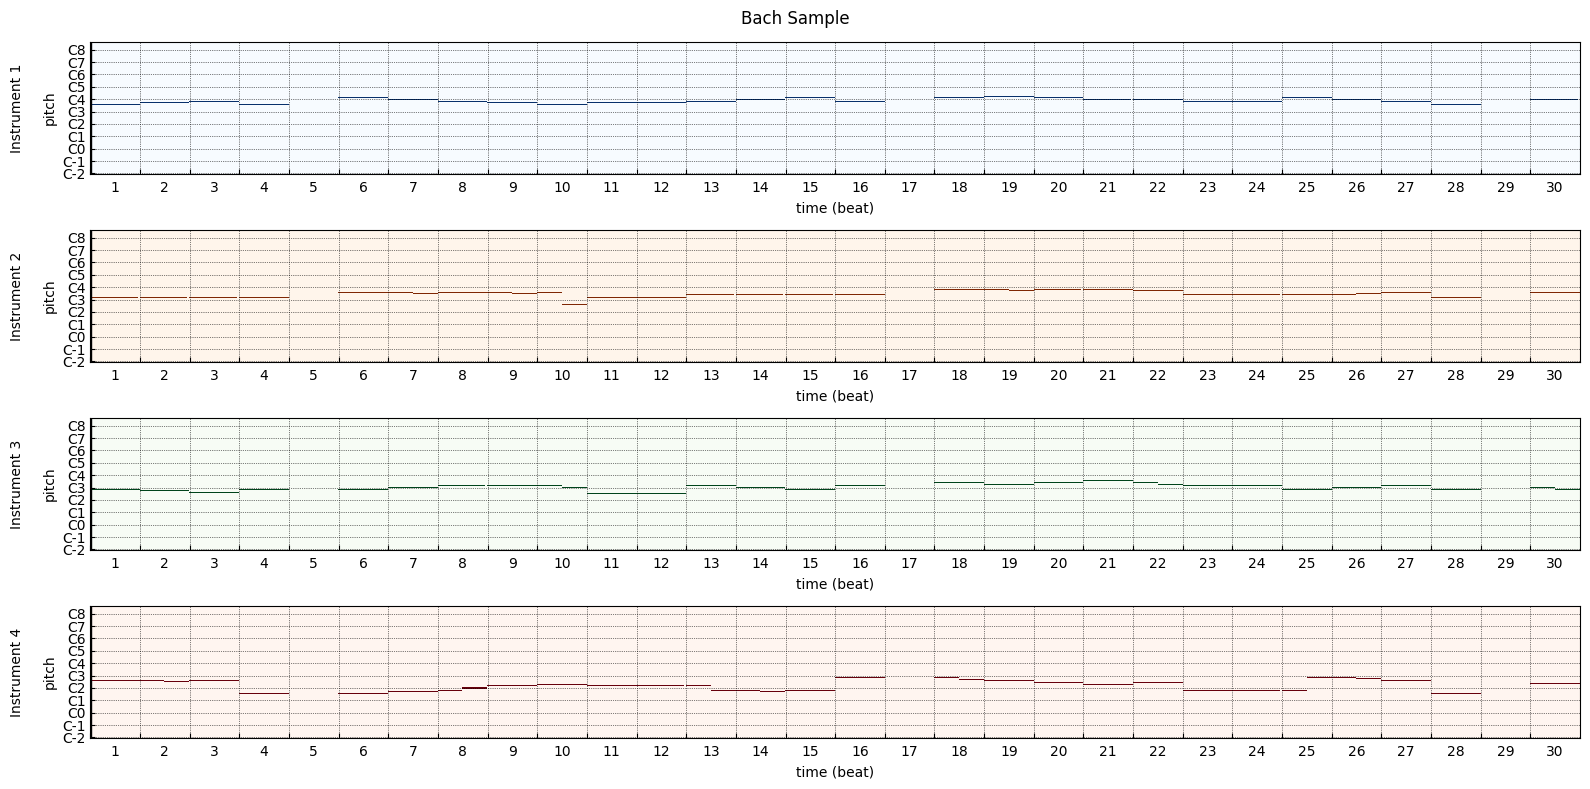

In [18]:
# Load a sample of a song by each composer and plot the piano roll
bach_sample_file = composers_df['song'][composers_df['composer'] == 'Bach'].iloc[100]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(bach_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 8))
multitrack.plot(axs=axs)
fig.suptitle('Bach Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
bach_pm = pretty_midi.PrettyMIDI(bach_sample_file)
display_audio(bach_pm)

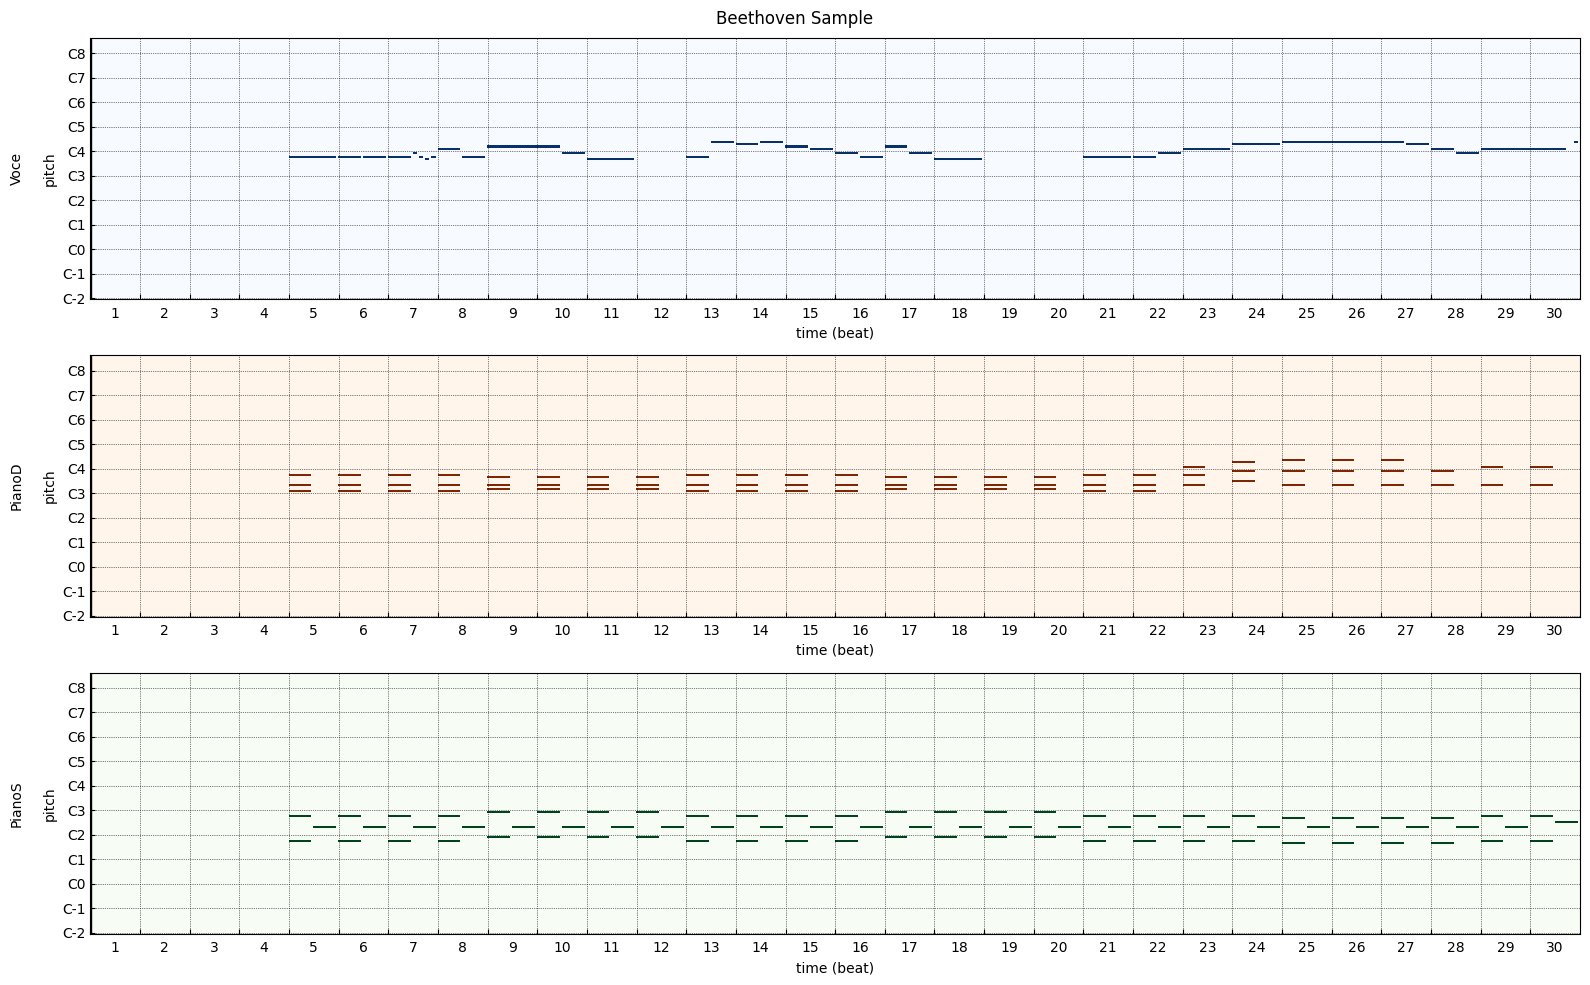

In [16]:
# Load a sample of a song by each composer and plot the piano roll
beethoven_sample_file = composers_df['song'][composers_df['composer'] == 'Beethoven'].iloc[22]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(beethoven_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 10))
multitrack.plot(axs=axs)
fig.suptitle('Beethoven Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
beethoven_pm = pretty_midi.PrettyMIDI(beethoven_sample_file)
display_audio(beethoven_pm)

### Extract piano rolls

In [723]:
# Set a sample file to test the feature extraction methods with
sample_file = '/content/composers/Chopin/19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid'

In [724]:
# Define a method for extracting pretty midi piano rolls
def extract_piano_roll(song_file_path, fs=100):
  try:
    pm = pretty_midi.PrettyMIDI(song_file_path)
    piano_roll = pm.get_piano_roll(fs=fs)

    return pd.Series([piano_roll])

  except Exception as e:
    print(f'Error processing {song_file_path} with pretty_midi')
    print(e)

  return pd.Series([np.nan])

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


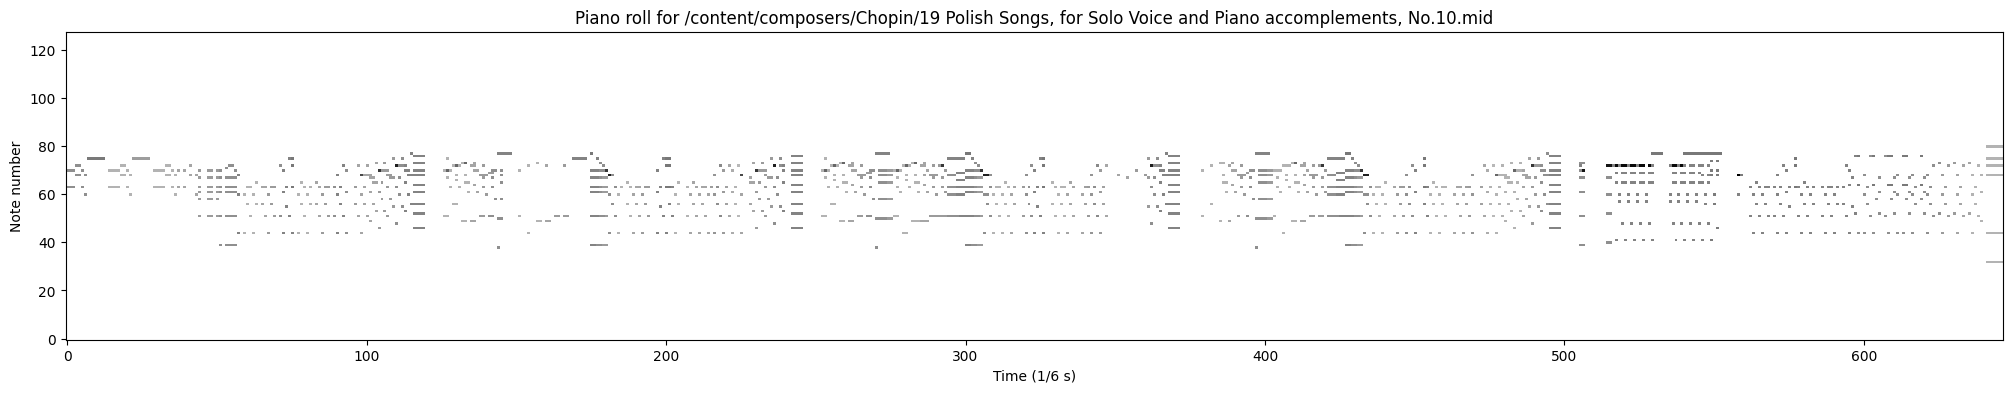

(128, 647)


In [725]:
# Test extract_piano_roll on one song
fs=6
piano_roll = extract_piano_roll(sample_file, fs=fs)

# Plot the piano roll
fig, ax = plt.subplots(figsize=(25, 4))
ax.imshow(
    piano_roll.values[0],
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='gray_r'
)
plt.xlabel(f'Time (1/{fs} s)')
plt.ylabel('Note number')
plt.title(f'Piano roll for {sample_file}')
plt.show()

print(piano_roll[0].shape)

In [726]:
# Apply to the whole dataframe
composers_df['piano_roll'] = composers_df['song'].apply(lambda song:
                                                        extract_piano_roll(song, fs=6))
composers_df.head()

Error processing /content/composers/Beethoven/Anhang 14-3.mid with pretty_midi
Could not decode key with 3 flats and mode 255
Error processing /content/composers/Mozart/K281 Piano Sonata n03 3mov.mid with pretty_midi
Could not decode key with 2 flats and mode 2
Error processing /content/composers/Mozart/K281 Piano Sonata n03 3mov.mid with pretty_midi
Could not decode key with 2 flats and mode 2
Error processing /content/composers/Mozart/K281 Piano Sonata n03 3mov.mid with pretty_midi
Could not decode key with 2 flats and mode 2


song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [727]:
# Drop the two songs that could not be parsed by pretty midi
composers_df.dropna(inplace=True)

### Extract instrument info

In [728]:
# Define method for using pretty midi to extract granular instrument info
def extract_instrument_info(song_file_path):
  try:
    # Instantiate a pretty midi object
    pm = pretty_midi.PrettyMIDI(song_file_path)
    instrument_ids = []
    instrument_classes = []
    num_instruments = len(pm.instruments)

    # For every instrument in the song, extract the class, id (program number), and name
    for instrument in pm.instruments:
      instrument_class = pretty_midi.program_to_instrument_class(instrument.program)
      instrument_ids.append(instrument.program)
      instrument_classes.append(instrument_class)

    return pd.Series([num_instruments, instrument_ids, instrument_classes])

  except Exception as e:
    print(f'Error processing {song_file_path} with pretty_midi')
    print(e)

  return pd.Series([np.nan, np.nan, np.nan])

In [729]:
# Test method on one song
extract_instrument_info(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0                    2
1              [0, 53]
2    [Piano, Ensemble]
dtype: object

In [730]:
# Apply instrument extraction method to the dataframe
composers_df[[
    'num_instruments',
    'instrument_ids',
    'instrument_classes'
]] = composers_df['song'].apply(extract_instrument_info)

composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  num_instruments  \
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   

     instrument_ids            instrument_classes  
708    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
1041   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
1466   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
876    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
712    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]

In [731]:
# View overall distribution of num_instruments
composers_df['num_instruments'].describe()

count    1236.000000
mean        5.761327
std         4.952944
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        40.000000
Name: num_instruments, dtype: float64

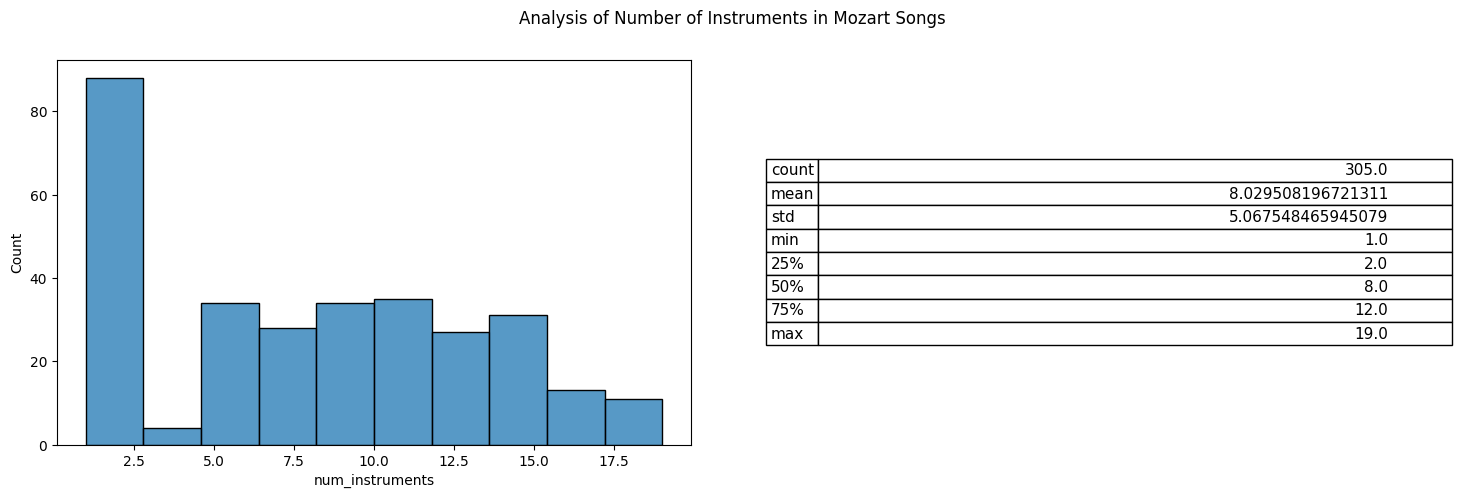

In [732]:
# Analyze the number of instruments in Mozart songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Mozart'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Mozart'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Mozart Songs')
plt.show()

In [733]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Mozart']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Ensemble': 900, 'Piano': 493, 'Reed': 382, 'Brass': 286, 'Strings': 267, 'Pipe': 96, 'Organ': 23, 'Synth Lead': 2})

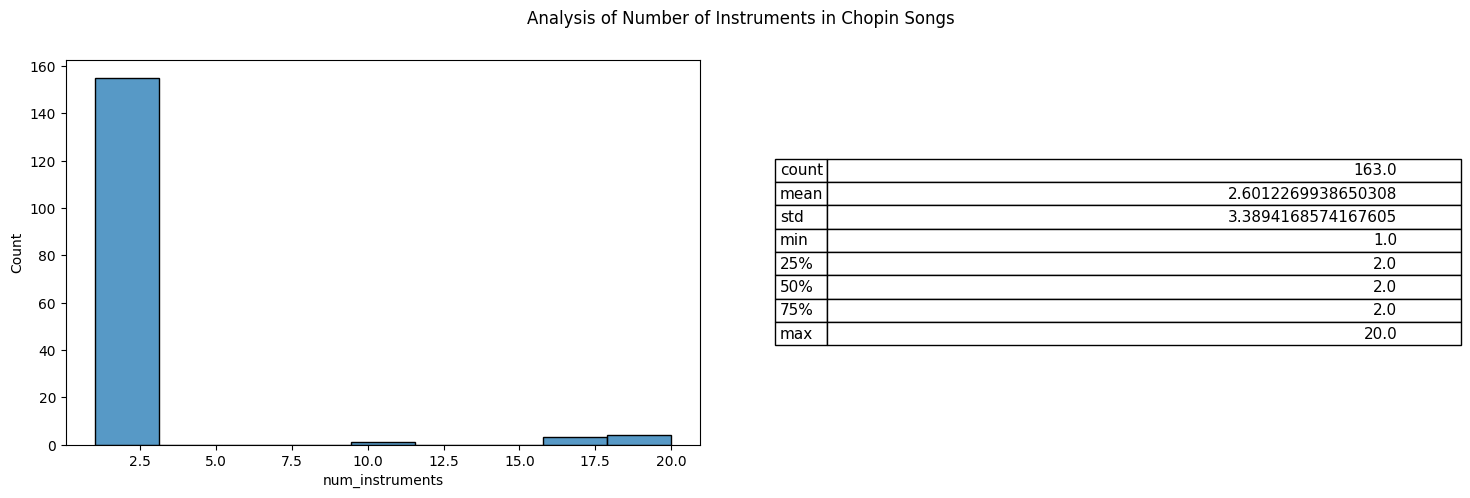

In [734]:
# Analyze the number of instruments in Chopin songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Chopin'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Chopin'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Chopin Songs')
plt.show()

In [735]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Chopin']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Piano': 277, 'Ensemble': 56, 'Strings': 34, 'Brass': 24, 'Reed': 23, 'Pipe': 8, 'Sound Effects': 2})

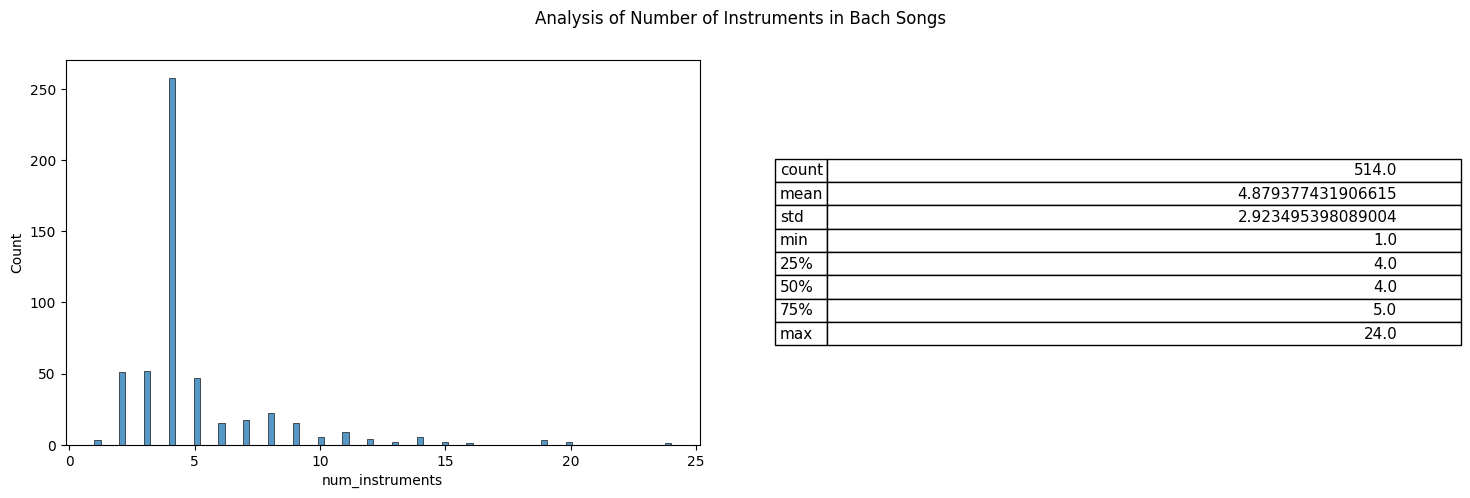

In [736]:
# Analyze the number of instruments in Bach songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Bach'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Bach'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Bach Songs')
plt.show()

In [737]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Bach']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Piano': 1701, 'Ensemble': 250, 'Strings': 248, 'Reed': 138, 'Organ': 52, 'Brass': 51, 'Pipe': 41, 'Guitar': 11, 'Chromatic Percussion': 8, 'Bass': 4, ...})

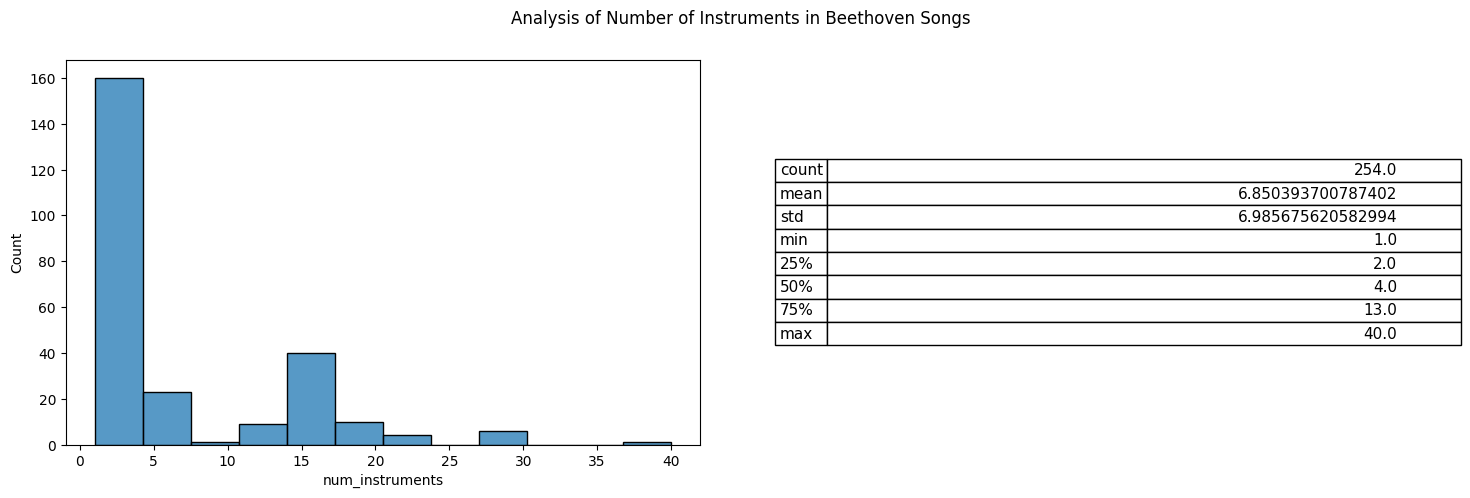

In [738]:
# Analyze the number of instruments in Beethoven songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Beethoven'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Beethoven'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Beethoven Songs')
plt.show()

In [739]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Beethoven']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Piano': 534, 'Ensemble': 416, 'Strings': 303, 'Reed': 219, 'Brass': 193, 'Pipe': 71, 'Bass': 4})

### Extract note sequences

In [740]:
# Define method for extracting notes from the songs
def extract_note_sequences(song_file_path):
  try:
    pm = pretty_midi.PrettyMIDI(song_file_path)
    note_sequence = []
    note_name_sequences = []

    # For each track, store the notes (pitch velocity duration)
    # as well as the names of each note
    for track_id, track in enumerate(pm.instruments):
      instrument_id = track.program
      note_names = []

      for note in track.notes:
        note_name = pretty_midi.note_number_to_name(note.pitch)
        note_names.append(note_name)
        pitch = note.pitch
        velocity = note.velocity
        duration = note.end - note.start
        note_sequence.append([pitch, velocity, duration, track_id, instrument_id])

      note_name_sequences.append(note_names)

    return pd.Series([np.array(note_sequence), note_name_sequences])

  except Exception as e:
    print(f'Error processing {song_file_path} with pretty midi')
    print(e)

  return pd.Series([np.nan, np.nan])

In [741]:
# Test on one sample file
extract_note_sequences(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0    [[70.0, 105.0, 0.24990780000000004, 0.0, 0.0],...
1    [[A#4, D#4, A#4, D#4, A#4, D#4, C5, G#4, A#4, ...
dtype: object

In [742]:
# Apply instrument extraction method to the dataframe
composers_df[[
    'note_sequences',
    'note_name_sequences'
]] = composers_df['song'].apply(extract_note_sequences)

composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  num_instruments  \
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   

     instrument_ids            instrument_classes  \
708    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1041   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1466   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
876    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
712    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   

                                         note_sequences  \
708   [[77.0, 96.0, 0.666666, 0.0, 0.0], [77.0, 96.0...   
1041  [[63.0, 96.0, 0.625, 0.0, 0.0], [63.0, 96.0, 0...   
1466  [[69.0, 96.0, 0.625, 0.0, 0.0], [67.0, 96.0, 0...   
876   [[74.0, 96.0, 1.276594, 0.0, 0.0], [77.0, 96.0...   
712   [[67.0, 96.0, 0.5769230000000001, 0.0, 0.0], [...   

                                    note_name_sequences  
708   [[F5, F5, C5, C#5, D#5, C#5, C5, C5, A#4, C#5,...  
1041  [[D#4, D#4, F4, G4, F4, D#4, G4, A4, A#4, A#4,...  
1466  [[A4, G4, F#4, B4, C#5, D5, D5, C#5, B4, C#5, ...  
876   [[D5, F5, D5, D5, D5, D5, D#5, D5, C5, C5, A#4...  
712   [[G4, G4, D#4, F4, G4, F4, D#4, D4, C4, G4, G4...

In [743]:
# View most commonly used notes for mozart
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Mozart'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'D4': 94426, 'D5': 85643, 'A4': 82402, 'G4': 72219, 'A3': 70578, 'E4': 69483, 'C4': 61348, 'E5': 60983, 'C5': 57161, 'G3': 55702, ...})

In [744]:
# View most commonly used notes for chopin
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Chopin'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'G#4': 12657, 'C4': 12440, 'C5': 12430, 'F4': 11845, 'D#4': 11102, 'G4': 11033, 'G#3': 10977, 'E4': 10876, 'A#4': 10279, 'D#5': 9785, ...})

In [745]:
# View most commonly used notes for bach
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Bach'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'A4': 46616, 'D5': 45568, 'G4': 38705, 'B4': 37452, 'D4': 35121, 'E5': 34857, 'C5': 31443, 'E4': 30814, 'A3': 27537, 'D3': 26407, ...})

In [746]:
# View most commonly used notes for beethoven
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Beethoven'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'D4': 75161, 'C4': 73420, 'G4': 70800, 'A4': 64990, 'G3': 64226, 'A3': 63786, 'F4': 61236, 'E4': 60566, 'D5': 60411, 'C5': 59557, ...})

### Extract song statistics

In [747]:
# Define method for extracting descriptive statistics from the songs
def extract_song_statistics(song_file_path):
  try:
    pm = pretty_midi.PrettyMIDI(song_file_path)
    song_duration = pm.get_end_time()
    total_notes = 0
    note_ids = []
    instrument_ids = []
    velocities = []
    durations = []

    for track in pm.instruments:
      instrument_ids.append(track.program)

      for note in track.notes:
          total_notes += 1
          note_ids.append(note.pitch)
          velocities.append(note.velocity)
          durations.append(note.end - note.start)

    most_frequent_note = max(set(note_ids), key = note_ids.count)
    most_frequent_instrument = max(set(instrument_ids), key = instrument_ids.count)

    min_note = np.min(note_ids)
    max_note = np.max(note_ids)

    mean_velocity = np.mean(velocities)
    min_velocity = np.min(velocities)
    max_velocity = np.max(velocities)

    mean_duration = np.mean(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    return pd.Series([
        song_duration,
        total_notes,
        most_frequent_note,
        most_frequent_instrument,
        min_note,
        max_note,
        mean_velocity,
        min_velocity,
        max_velocity,
        mean_duration,
        min_duration,
        max_duration
    ])

  except Exception as e:
    print(f'Error processing {song_file_path} with pretty midi')
    print(e)

  return pd.Series([np.nan] * 12)

In [748]:
# Test on one sample file
extract_song_statistics(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0      107.915869
1     1742.000000
2       63.000000
3        0.000000
4       32.000000
5       80.000000
6       97.889782
7       66.000000
8      127.000000
9        0.158194
10       0.020826
11       2.166740
dtype: float64

In [749]:
# Apply song statistics method to the dataframe
composers_df[[
    'song_duration',
    'total_notes',
    'most_frequent_note',
    'most_frequent_instrument',
    'min_note',
    'max_note',
    'mean_velocity',
    'min_velocity',
    'max_velocity',
    'mean_duration',
    'min_duration',
    'max_duration'
]] = composers_df['song'].apply(extract_song_statistics)

composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  num_instruments  \
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   

     instrument_ids            instrument_classes  \
708    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1041   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1466   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
876    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
712    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   

                                         note_sequences  \
708   [[77.0, 96.0, 0.666666, 0.0, 0.0], [77.0, 96.0...   
1041  [[63.0, 96.0, 0.625, 0.0, 0.0], [63.0, 96.0, 0...   
1466  [[69.0, 96.0, 0.625, 0.0, 0.0], [67.0, 96.0, 0...   
876   [[74.0, 96.0, 1.276594, 0.0, 0.0], [77.0, 96.0...   
712   [[67.0, 96.0, 0.5769230000000001, 0.0, 0.0], [...   

                                    note_name_sequences  song_duration  \
708   [[F5, F5, C5, C#5, D#5, C#5, C5, C5, A#4, C#5,...      42.666624   
1041  [[D#4, D#4, F4, G4, F4, D#4, G4, A4, A#4, A#4,...      62.500000   
1466  [[A4, G4, F#4, B4, C#5, D5, D5, C#5, B4, C#5, ...      30.000000   
876   [[D5, F5, D5, D5, D5, D5, D#5, D5, C5, C5, A#4...      56.170136   
712   [[G4, G4, D#4, F4, G4, F4, D#4, D4, C4, G4, G4...      29.999996   

      total_notes  most_frequent_note  most_frequent_instrument  min_note  \
708         318.0                65.0                       0.0      44.0   
1041        458.0                63.0                       0.0      39.0   
1466        213.0                57.0                       0.0      43.0   
876         205.0                60.0                       0.0      43.0   
712         228.0                60.0                       0.0      43.0   

      max_note  mean_velocity  min_velocity  max_velocity  mean_duration  \
708       78.0           96.0          96.0          96.0       0.536687   
1041      75.0           96.0          96.0          96.0       0.529476   
1466      78.0           96.0          96.0          96.0       0.563380   
876       77.0           96.0          96.0          96.0       1.077321   
712       75.0           96.0          96.0          96.0       0.495951   

      min_duration  max_duration  
708       0.333333      1.333332  
1041      0.156250      1.250000  
1466      0.156250      1.250000  
876       0.638297      7.659564  
712       0.288461      1.153846

count    1236.000000
mean      292.597162
std       321.095042
min        17.500000
25%        66.923068
50%       204.809498
75%       404.032634
max      5032.305478
Name: song_duration, dtype: float64


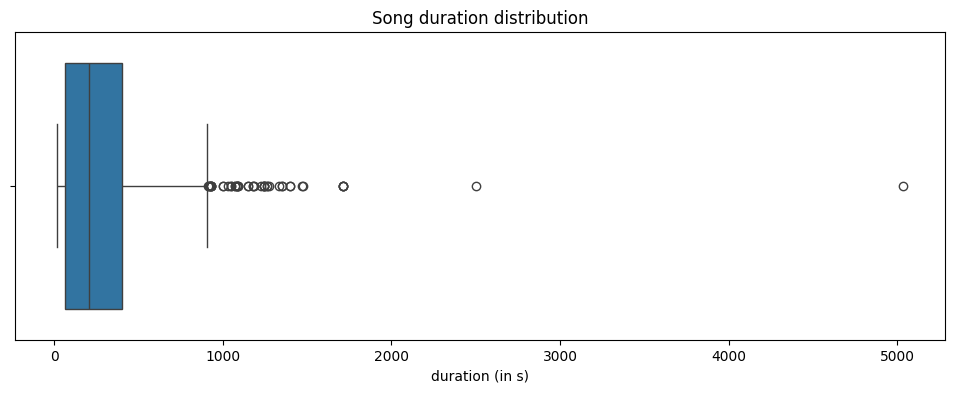

In [750]:
# Print descriptive statistics for song durations
print(composers_df['song_duration'].describe())

# Plot overall distribution of song durations
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=composers_df, x='song_duration')
ax.set_title('Song duration distribution')
ax.set_xlabel('duration (in s)')
plt.show()

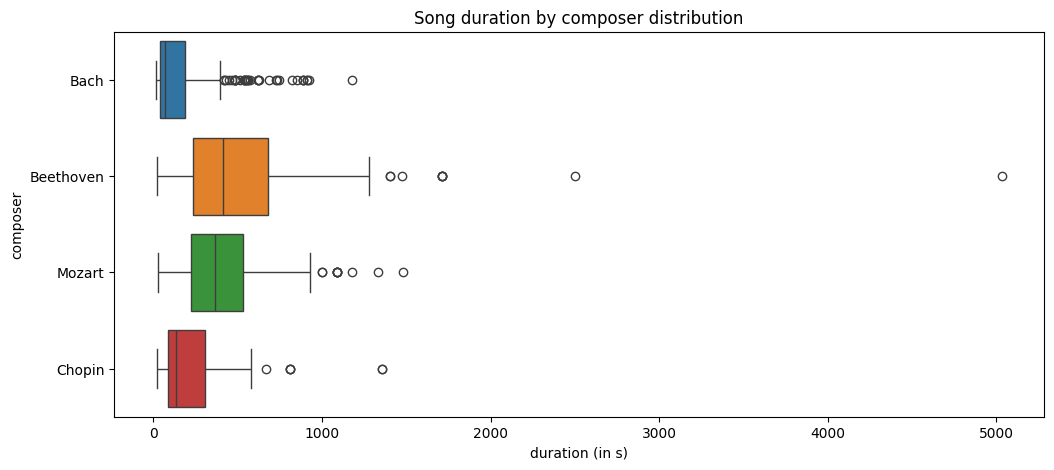

In [751]:
# Plot the distribution of song durations by composer
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(
    data=composers_df,
    x='song_duration',
    y='composer',
    hue='composer',
    ax=ax
)
ax.set_title('Song duration by composer distribution')
ax.set_xlabel('duration (in s)')
plt.show()

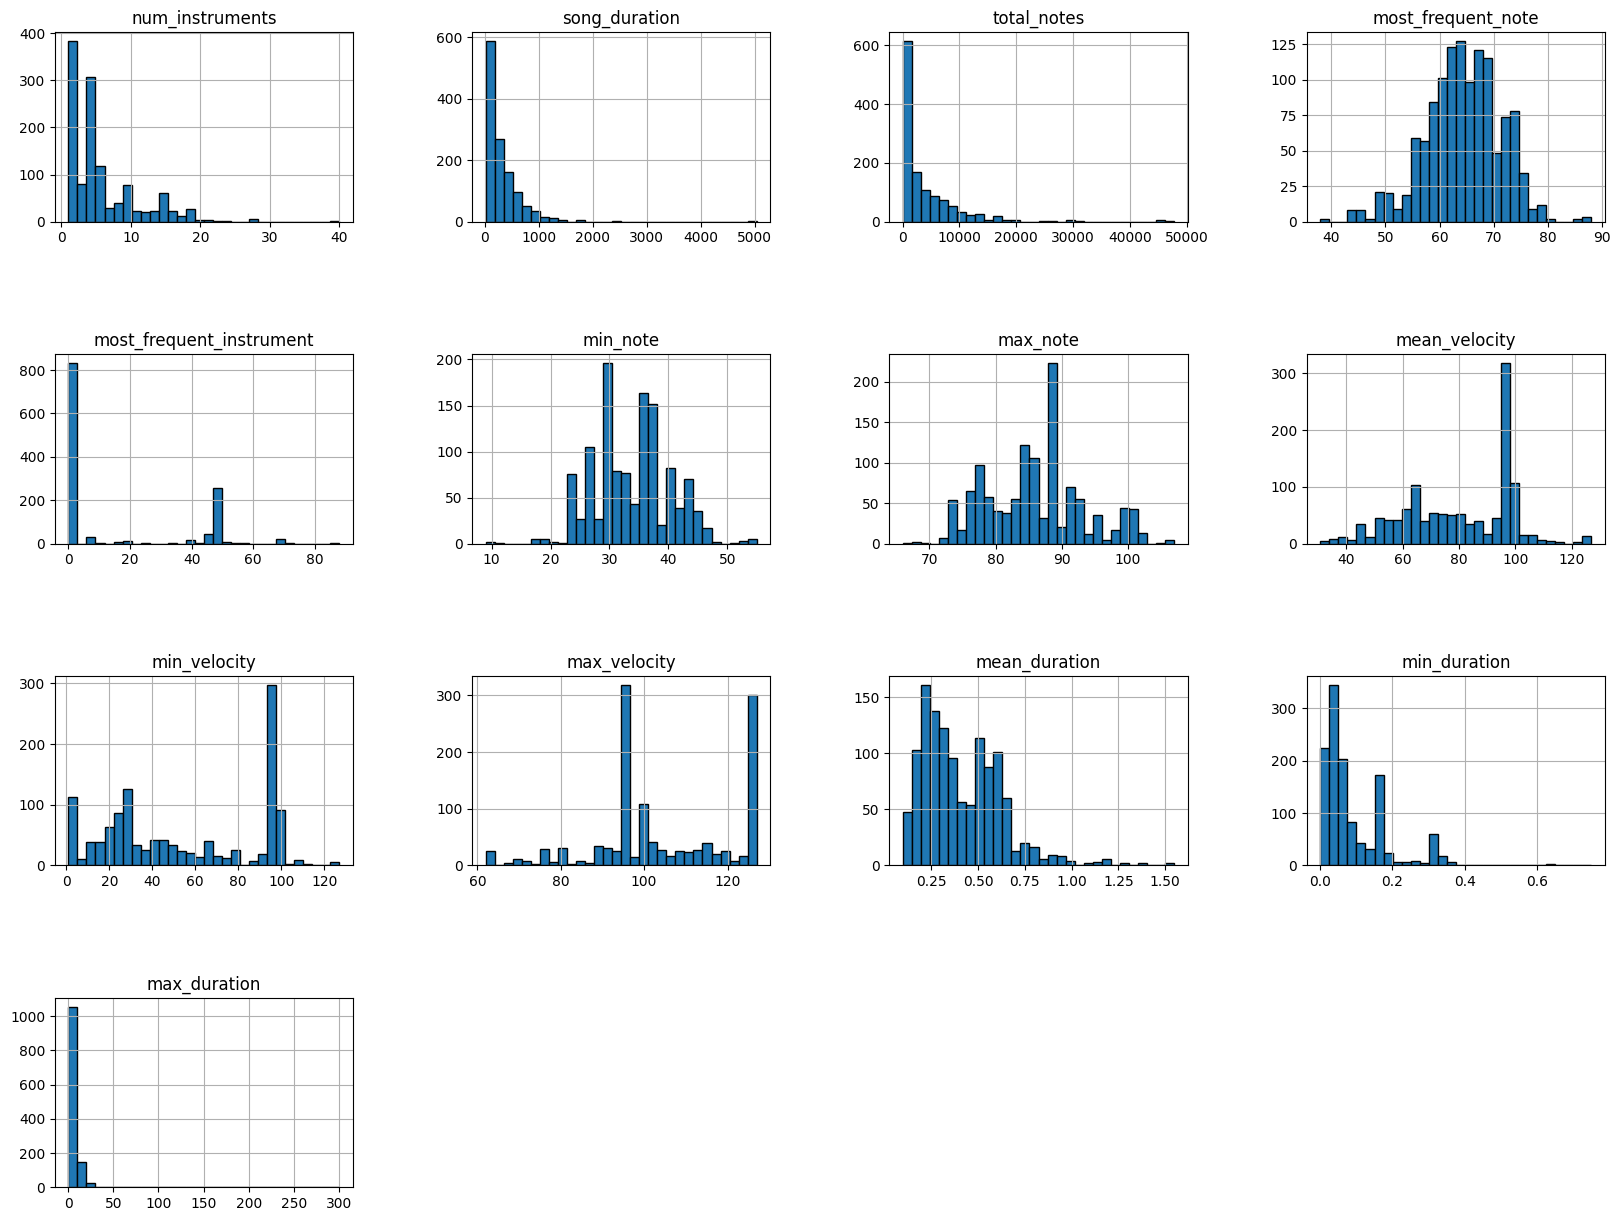

In [752]:
# Examine the distribution of each of the variables
composers_df[[
    'num_instruments',
    'song_duration',
    'total_notes',
    'most_frequent_note',
    'most_frequent_instrument',
    'min_note',
    'max_note',
    'mean_velocity',
    'min_velocity',
    'max_velocity',
    'mean_duration',
    'min_duration',
    'max_duration',
  ]].hist(figsize=(20, 15), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

### Extract all features

In [11]:
# Set a sample file to test the feature extraction methods with
sample_file = '/content/composers/Chopin/19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid'

In [12]:
# Define a method that extracts all of the above features at once
# use_piano_rolls determines whether to extract piano rolls or
# note sequences
def extract_all_features(song_file_path, use_piano_rolls, fs=100):
  try:
    # Instantiate a pretty midi object
    pm = pretty_midi.PrettyMIDI(song_file_path)

    instrument_ids = []
    num_instruments = len(pm.instruments)

    song_duration = pm.get_end_time()
    total_notes = 0
    note_ids = []
    velocities = []
    durations = []

    # For every instrument in the song, extract the id (program number)
    for instrument in pm.instruments:
      instrument_ids.append(instrument.program)

      for note in instrument.notes:
          total_notes += 1
          note_ids.append(note.pitch)
          velocities.append(note.velocity)
          durations.append(note.end - note.start)

    # Compute song statistics
    most_frequent_note = max(set(note_ids), key = note_ids.count)
    most_frequent_instrument = max(set(instrument_ids), key = instrument_ids.count)

    min_note = np.min(note_ids)
    max_note = np.max(note_ids)

    mean_velocity = np.mean(velocities)
    min_velocity = np.min(velocities)
    max_velocity = np.max(velocities)

    mean_duration = np.mean(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    # If using piano rolls, get the piano roll for the song
    if use_piano_rolls:
      piano_roll = pm.get_piano_roll(fs=fs)

      return pd.Series([
          num_instruments,
          song_duration,
          total_notes,
          most_frequent_note,
          most_frequent_instrument,
          min_note,
          max_note,
          mean_velocity,
          min_velocity,
          max_velocity,
          mean_duration,
          min_duration,
          max_duration,
          piano_roll
      ])

    # Else, include the note sequences
    else:
      note_sequence = []

      # For each track, store the notes (pitch velocity duration)
      # as well as their instruments and track id
      for track_id, track in enumerate(pm.instruments):
        instrument_id = track.program

        for note in track.notes:
          pitch = note.pitch
          velocity = note.velocity
          duration = note.end - note.start
          note_sequence.append([pitch, velocity, duration, track_id, instrument_id])

      return pd.Series([
          num_instruments,
          song_duration,
          total_notes,
          most_frequent_note,
          most_frequent_instrument,
          min_note,
          max_note,
          mean_velocity,
          min_velocity,
          max_velocity,
          mean_duration,
          min_duration,
          max_duration,
          np.array(note_sequence)
      ])

  # Handle files that can't be read by pretty midi
  except Exception as e:
    print(f'Error processing {song_file_path} with pretty_midi')
    print(e)

  return pd.Series([np.nan] * 14)

In [13]:
# Test feature extraction on one song
sample_features = extract_all_features(sample_file, use_piano_rolls=True, fs=1)
sample_features

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0                                                     2
1                                            107.915869
2                                                  1742
3                                                    63
4                                                     0
5                                                    32
6                                                    80
7                                             97.889782
8                                                    66
9                                                   127
10                                             0.158194
11                                             0.020826
12                                              2.16674
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [14]:
# Specifiy whether to extract either piano rolls or note sequences
use_piano_rolls = False

if use_piano_rolls:
  # Apply to whole dataframe (using piano rolls)
  composers_df[[
        'num_instruments',
        'song_duration',
        'total_notes',
        'most_frequent_note',
        'most_frequent_instrument',
        'min_note',
        'max_note',
        'mean_velocity',
        'min_velocity',
        'max_velocity',
        'mean_duration',
        'min_duration',
        'max_duration',
        'piano_roll'
  ]] = composers_df['song'].apply(lambda song: extract_all_features(
                                                song, use_piano_rolls=True, fs=5))
else:
  # Apply to whole dataframe (using note_sequences)
  composers_df[[
        'num_instruments',
        'song_duration',
        'total_notes',
        'most_frequent_note',
        'most_frequent_instrument',
        'min_note',
        'max_note',
        'mean_velocity',
        'min_velocity',
        'max_velocity',
        'mean_duration',
        'min_duration',
        'max_duration',
        'note_sequence'
  ]] = composers_df['song'].apply(lambda song: extract_all_features(
                                                song, use_piano_rolls=False))

Error processing /content/composers/Beethoven/Anhang 14-3.mid with pretty_midi
Could not decode key with 3 flats and mode 255
Error processing /content/composers/Mozart/K281 Piano Sonata n03 3mov.mid with pretty_midi
Could not decode key with 2 flats and mode 2


In [15]:
# Drop the songs that were not processed correctly
composers_df.dropna(inplace=True)

In [24]:
composers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1529 entries, 0 to 1530
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   song                      1529 non-null   object 
 1   composer                  1529 non-null   object 
 2   num_instruments           1529 non-null   float64
 3   song_duration             1529 non-null   float64
 4   total_notes               1529 non-null   float64
 5   most_frequent_note        1529 non-null   float64
 6   most_frequent_instrument  1529 non-null   float64
 7   min_note                  1529 non-null   float64
 8   max_note                  1529 non-null   float64
 9   mean_velocity             1529 non-null   float64
 10  min_velocity              1529 non-null   float64
 11  max_velocity              1529 non-null   float64
 12  mean_duration             1529 non-null   float64
 13  min_duration              1529 non-null   float64
 14  max_duration 

## Data Preprocessing

### Encode target labels

In [753]:
# Encode the class labels as integers
label_encoder = preprocessing.LabelEncoder()
composers_df['composer_encoded'] = label_encoder.fit_transform(composers_df['composer'])

composers_df['composer_encoded'].unique()

array([0, 1, 3, 2])

### Preprocess piano rolls

In [754]:
# Define a method that pads or truncates piano rolls to be the same length
def pad_piano_roll(piano_roll, seq_length):
  # Define a new piano roll with the shape (128, seq_length)
  padded_piano_roll = np.zeros((piano_roll.shape[0], seq_length), dtype=np.float32)

  # If the piano roll is shorter than the sequence length, add padding
  if piano_roll.shape[1] < seq_length:
    padded_piano_roll[:, :piano_roll.shape[1]] = piano_roll[:, :]

  # If the piano roll is too long, truncate it
  elif piano_roll.shape[1] > seq_length:
    padded_piano_roll[:, :seq_length] = piano_roll[:, :seq_length]

  # Handle edge case where the piano roll is already the exact maximum length
  else:
    padded_piano_roll = piano_roll

  return padded_piano_roll

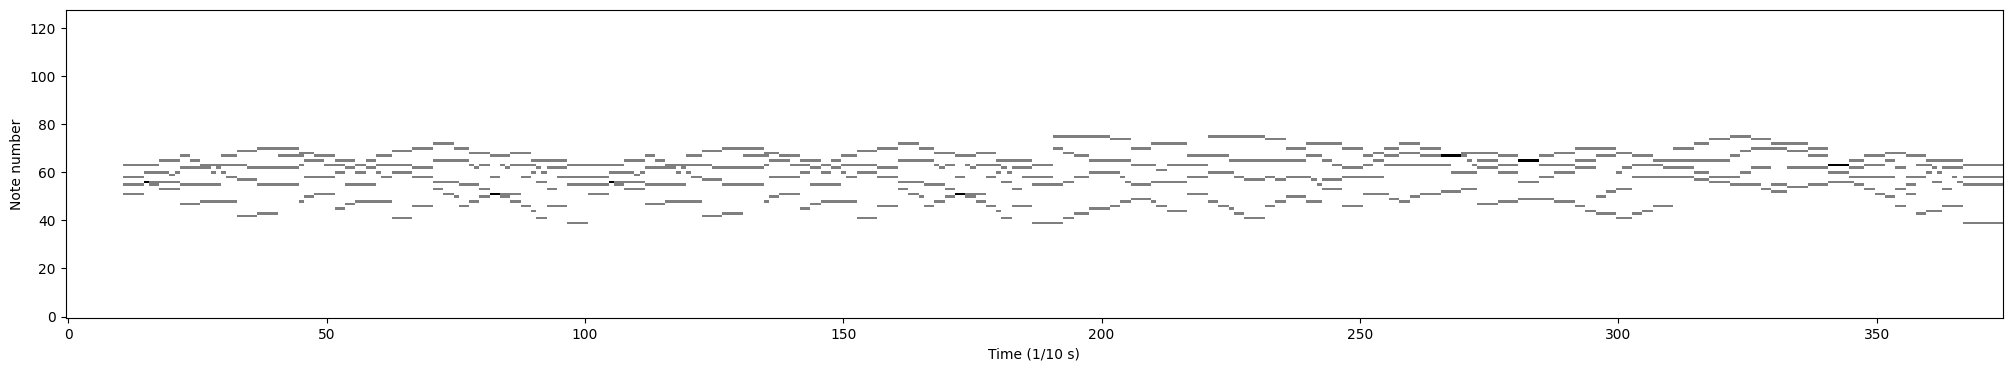

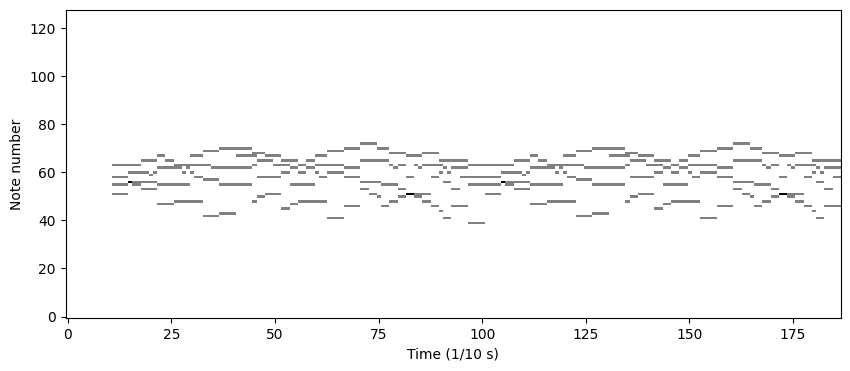

In [755]:
# Test function
sample_piano_roll = composers_df['piano_roll'].iloc[1]
max_length = int(sample_piano_roll.shape[1] * 0.5)

# Plot piano roll before padding/truncation
fig, ax = plt.subplots(figsize=(25, 4))
ax.imshow(
    sample_piano_roll,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='gray_r'
)
plt.xlabel('Time (1/10 s)')
plt.ylabel('Note number')
plt.show()

sample_padded_piano_roll = pad_piano_roll(sample_piano_roll, max_length)

# Plot piano roll after padding/truncation
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(
    sample_padded_piano_roll,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='gray_r'
)
plt.xlabel('Time (1/10 s)')
plt.ylabel('Note number')
plt.show()

In [756]:
# Since the length of the piano rolls has a lot of outliers, set the maximum
# sequence length for the  to be the 75th percentile
piano_roll_ts = composers_df['piano_roll'].apply(lambda x: x.T.shape[0]).values
max_length = int(np.percentile(piano_roll_ts, 50))

# Pad the piano rolls to be the same length
composers_df['piano_roll'] = composers_df['piano_roll'].apply(lambda roll: pad_piano_roll(roll, max_length))

# Transpose the piano rolls so they have the shape (time_steps, notes)
composers_df['piano_roll'] = composers_df['piano_roll'].apply(lambda roll: roll.T)

In [757]:
# Print new shape of the piano rolls
composers_df['piano_roll'].iloc[1].shape

(1228, 128)

### Preprocess note sequences

In [296]:
# Define a method that pads or truncates note sequences to be the same length
def pad_note_sequence(note_sequence, seq_length):
  # Define a new note sequence of the specified sequence length
  padded_note_sequence = np.zeros((seq_length, note_sequence.shape[1]), dtype=np.float32)

  # If the note sequence is shorter than the sequence length, add padding
  if note_sequence.shape[0] < seq_length:
    padded_note_sequence[:note_sequence.shape[0], :] = note_sequence[:, :]

  # If the note sequence is too long, truncate it
  elif note_sequence.shape[0] > seq_length:
    padded_note_sequence[:seq_length, :] = note_sequence[:seq_length, :]

  # Handle edge case where the note sequence is already the exact maximum length
  else:
    padded_note_sequence = note_sequence

  return padded_note_sequence

In [297]:
# Test the padding method
sample_note_sequence = composers_df['note_sequence'].iloc[0]
print(sample_note_sequence.shape)

max_length = 500
sample_note_sequence_padded = pad_note_sequence(sample_note_sequence, max_length)
print(sample_note_sequence_padded.shape)

max_length = 5000
sample_note_sequence_padded = pad_note_sequence(sample_note_sequence, max_length)
print(sample_note_sequence_padded.shape)

(318, 5)
(500, 5)
(5000, 5)


In [298]:
# Determine the maximum length for the note sequences
note_sequence_lengths = composers_df['note_sequence'].apply(lambda x: x.shape[0]).values
max_length = int(np.percentile(note_sequence_lengths, 75))

In [299]:
# Pad the note sequences to be the same length
composers_df['note_sequence'] = composers_df['note_sequence'].apply(lambda seq:
                                                                    pad_note_sequence(seq, max_length))

### Split the data

In [758]:
# Split the data into train and test sets
train_df, test_df = train_test_split(composers_df, test_size=0.2, random_state=42)

### Normalize non-sequential features

In [759]:
non_sequential_features = [
    'num_instruments',
    'song_duration',
    'total_notes',
    'most_frequent_note',
    'most_frequent_instrument',
    'min_note',
    'max_note',
    'mean_velocity',
    'min_velocity',
    'max_velocity',
    'mean_duration',
    'min_duration',
    'max_duration',
]


In [760]:
composers_df[non_sequential_features].describe()

num_instruments  song_duration   total_notes  most_frequent_note  \
count      1236.000000    1236.000000   1236.000000         1236.000000   
mean          5.761327     292.597162   3934.621359           64.152104   
std           4.952944     321.095042   5417.893564            7.125446   
min           1.000000      17.500000     83.000000           38.000000   
25%           2.000000      66.923068    492.000000           60.000000   
50%           4.000000     204.809498   1693.000000           64.000000   
75%           8.000000     404.032634   5712.000000           69.000000   
max          40.000000    5032.305478  47745.000000           88.000000   

       most_frequent_instrument     min_note     max_note  mean_velocity  \
count               1236.000000  1236.000000  1236.000000    1236.000000   
mean                  14.446602    33.851133    85.991100      80.066980   
std                   22.249987     6.537008     7.430591      19.045231   
min                    0.000000     9.000000    66.000000      30.812865   
25%                    0.000000    29.000000    80.000000      64.000000   
50%                    0.000000    34.000000    86.000000      82.546099   
75%                   45.000000    38.000000    90.000000      96.000000   
max                   88.000000    55.000000   107.000000     127.000000   

       min_velocity  max_velocity  mean_duration  min_duration  max_duration  
count   1236.000000   1236.000000    1236.000000   1236.000000   1236.000000  
mean      54.767799    104.584951       0.409856      0.092209      6.062445  
std       35.812991     16.661480       0.211902      0.091303     13.922485  
min        1.000000     62.000000       0.098049      0.000500      0.277144  
25%       24.000000     96.000000       0.242430      0.033296      1.818268  
50%       48.000000    100.000000       0.355218      0.056818      3.305550  
75%       96.000000    124.000000       0.553471      0.151562      7.114065  
max      127.000000    127.000000       1.547299      0.750000    300.481875

In [761]:
# Initialize a StandardScaler
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
# Normalize the non-sequential features
train_df[non_sequential_features] = scaler.fit_transform(train_df[non_sequential_features])
test_df[non_sequential_features] = scaler.transform(test_df[non_sequential_features])

In [762]:
train_df[non_sequential_features].shape

(988, 13)

In [763]:
x_non_seq_train = train_df[non_sequential_features]
x_non_seq_test = test_df[non_sequential_features]

### Normalize the piano rolls

In [764]:
# Initialize a StandardScaler
scaler = preprocessing.StandardScaler()

# Fit the scaler on all the rows of the training set
scaler.fit(np.vstack(train_df['piano_roll'].values))

# Use the fitted StandardScaler to transform the training and test piano rolls
train_df['piano_roll'] = train_df['piano_roll'].apply(lambda roll: scaler.transform(roll))
test_df['piano_roll'] = test_df['piano_roll'].apply(lambda roll: scaler.transform(roll))


### Normalize the note sequences

In [379]:
# Initialize a StandardScaler
scaler = preprocessing.StandardScaler()

# Fit the scaler on all the rows of the training set
scaler.fit(np.vstack([notes[:, :-2] for notes in train_df['note_sequence']]))

# Use the fitted StandardScaler to transform the training and test note sequences
train_df['note_sequence'] = train_df['note_sequence'].apply(lambda notes: scaler.transform(notes[:,:-2]))
test_df['note_sequence'] = test_df['note_sequence'].apply(lambda notes: scaler.transform(notes[:,:-2]))

### Window the sequential data

In [765]:
# Define a function that breaks the data into windows for training and testing
def generate_windows(sequences, window_size, stride, piano_roll):
  all_windows = []
  all_labels = []

  for sequence, label in sequences:
    seq_windows = []
    num_windows = sequence.shape[0] // stride if piano_roll else len(sequence) // stride

    for i in range(num_windows):
      window_start = i * stride
      window_end = window_start + window_size

      if window_end <= len(sequence):
        window = sequence[window_start:window_end]
        seq_windows.append(window)

    all_windows.append(seq_windows)
    all_labels.append(label)

  return np.expand_dims(np.array(all_windows), axis=-1), np.array(all_labels)

In [772]:
# Generate piano roll windows for the training and test sets
if use_piano_rolls:
    window_size = 128
    stride = 64
    train_sequences = list(zip(train_df['piano_roll'], train_df['composer_encoded']))

    train_windows, train_labels = generate_windows(train_sequences, window_size, stride, piano_roll=True)
    print(f"Sequential training data shape: {train_windows.shape}")

    test_sequences = list(zip(test_df['piano_roll'], test_df['composer_encoded']))

    test_windows, test_labels = generate_windows(test_sequences, window_size, stride, piano_roll=True)
    print(f"Sequential test data shape: {test_windows.shape}")

# Geneare note sequence windows for the training and test sets
else:
    window_size = 256
    stride = 128
    train_sequences = list(zip(train_df['note_sequence'], train_df['composer_encoded']))

    train_windows, train_labels = generate_windows(train_sequences, window_size, stride, piano_roll=False)
    print(f"Sequential training data shape: {train_windows.shape}")

    test_sequences = list(zip(test_df['note_sequence'], test_df['composer_encoded']))

    test_windows, test_labels = generate_windows(test_sequences, window_size, stride, piano_roll=False)
    print(f"Sequential test data shape: {test_windows.shape}")

y_train = train_labels
print(f"Training label shape: {y_train.shape}")

y_test = test_labels
print(f"Test label shape: {y_test.shape}")

Sequential training data shape: (988, 18, 128, 128, 1)
Sequential test data shape: (248, 18, 128, 128, 1)
Training label shape: (988,)
Test label shape: (248,)


## Model Building, Training, Evaluation, and Optimization


### CNN-LSTM: Piano roll model before optimization

In [844]:
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

x = layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same'))(seq_input)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

x = layers.LSTM(16)(x)

y = layers.Dense(32, activation='relu')(non_seq_input)

combined = layers.Concatenate()([x, y])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)
output = layers.Dense(units = 4, activation ='softmax')(z)

In [845]:
pianoroll_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
pianoroll_model.summary()

Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_188           │ (None, 18, 128, 128,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_341      │ (None, 18, 128, 128,   │            320 │ input_layer_188[0][0]  │
│ (TimeDistributed)         │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_342      │ (None, 18, 64, 64, 32) │              0 │ time_distributed_341[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_343      │ (None, 18, 131072)     │              0 │ time_distributed_342[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_189           │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_93 (LSTM)            │ (None, 16)             │      8,389,696 │ time_distributed_343[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_448 (Dense)         │ (None, 32)             │            448 │ input_layer_189[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_93            │ (None, 48)             │              0 │ lstm_93[0][0],         │
│ (Concatenate)             │                        │                │ dense_448[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_449 (Dense)         │ (None, 64)             │          3,136 │ concatenate_93[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_450 (Dense)         │ (None, 32)             │          2,080 │ dense_449[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_451 (Dense)         │ (None, 4)              │            132 │ dense_450[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,395,812 (32.03 MB)

 Trainable params: 8,395,812 (32.03 MB)

 Non-trainable params: 0 (0.00 B)

In [846]:
pianoroll_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [847]:
# Train the model
history = pianoroll_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  epochs=20
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.4116 - loss: 1.3011 - val_accuracy: 0.7379 - val_loss: 0.9307
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7216 - loss: 0.8711 - val_accuracy: 0.7621 - val_loss: 0.7081
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7944 - loss: 0.6380 - val_accuracy: 0.8145 - val_loss: 0.5702
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8560 - loss: 0.5063 - val_accuracy: 0.8266 - val_loss: 0.4809
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8537 - loss: 0.4327 - val_accuracy: 0.8548 - val_loss: 0.4285
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8780 - loss: 0.3554 - val_accuracy: 0.8508 - val_loss: 0.4332
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8844 - loss: 0.3203 - val_accuracy: 0.8589 - val_loss: 0.3897
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9113 - loss: 0.2500 - val_accuracy: 0.

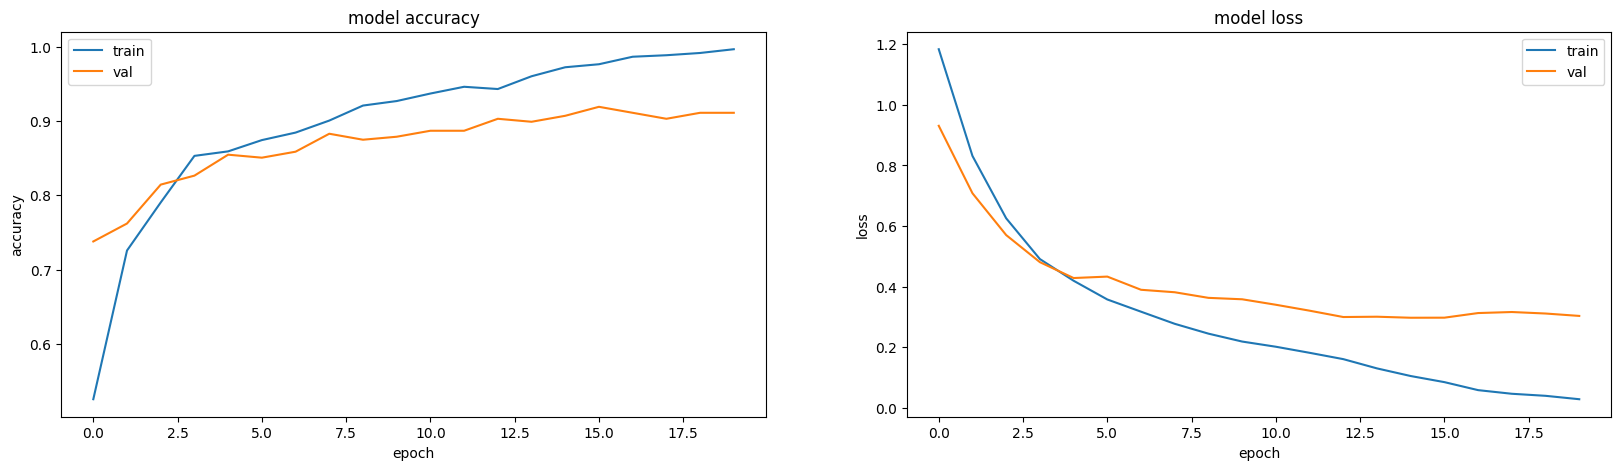

In [848]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [849]:
# Evaluate the model on the test set
test_loss, test_acc = pianoroll_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9228 - loss: 0.2591
Test Loss: 0.3035
Test Accuracy: 0.9113


In [850]:
# Generate predicted probabilities for the test set
y_pred = pianoroll_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       110
           1       0.87      0.94      0.90        50
           2       0.93      0.90      0.92        31
           3       0.86      0.84      0.85        57

    accuracy                           0.91       248
   macro avg       0.90      0.91      0.90       248
weighted avg       0.91      0.91      0.91       248



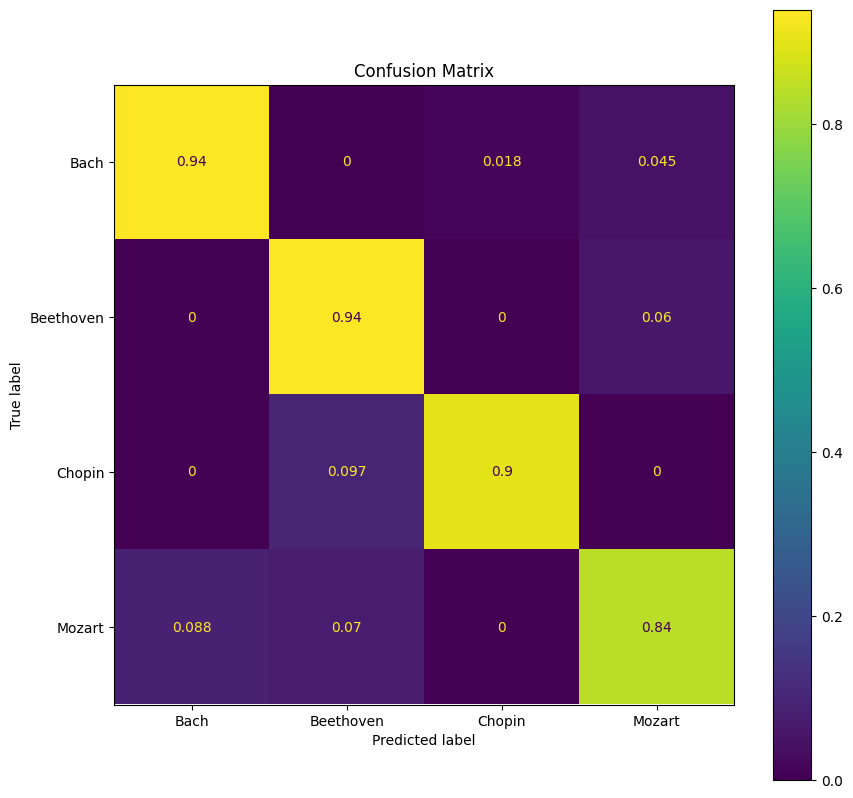

In [851]:
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

### CNN-LSTM: Piano roll model after optimization

In [828]:
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

x = layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)))(seq_input)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

x = layers.LSTM(32)(x)

y = layers.Dense(64, activation='relu')(non_seq_input)

combined = layers.Concatenate()([x, y])

z = layers.Dense(128, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)
output = layers.Dense(units = 4, activation ='softmax')(z)

In [829]:
pianoroll_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
pianoroll_model.summary()

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_184           │ (None, 18, 128, 128,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_335      │ (None, 18, 128, 128,   │            320 │ input_layer_184[0][0]  │
│ (TimeDistributed)         │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_336      │ (None, 18, 64, 64, 32) │              0 │ time_distributed_335[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_337      │ (None, 18, 131072)     │              0 │ time_distributed_336[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_185           │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_91 (LSTM)            │ (None, 32)             │     16,781,440 │ time_distributed_337[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_440 (Dense)         │ (None, 64)             │            896 │ input_layer_185[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_91            │ (None, 96)             │              0 │ lstm_91[0][0],         │
│ (Concatenate)             │                        │                │ dense_440[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_441 (Dense)         │ (None, 128)            │         12,416 │ concatenate_91[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_442 (Dense)         │ (None, 32)             │          4,128 │ dense_441[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_443 (Dense)         │ (None, 4)              │            132 │ dense_442[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 16,799,332 (64.08 MB)

 Trainable params: 16,799,332 (64.08 MB)

 Non-trainable params: 0 (0.00 B)

In [830]:
pianoroll_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [831]:
# Create an early stopping callback to stop training the model once loss plataues
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=True
)

# Create a callback to reduce the learning rate by a factor of 0.1 if validation
# accuracy does not approve for more than the specified number of epochs
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=4,
    min_delta=0.01
)

# Train the model
history = pianoroll_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  batch_size=16,
  epochs=30,
  callbacks=[es_callback, lr_callback]
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6059 - loss: 1.0207 - val_accuracy: 0.7177 - val_loss: 0.7351 - learning_rate: 0.0010
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7690 - loss: 0.6131 - val_accuracy: 0.7984 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8168 - loss: 0.5050 - val_accuracy: 0.8347 - val_loss: 0.4599 - learning_rate: 0.0010
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8406 - loss: 0.3940 - val_accuracy: 0.8468 - val_loss: 0.4142 - learning_rate: 0.0010
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8731 - loss: 0.3588 - val_accuracy: 0.8871 - val_loss: 0.3259 - learning_rate: 0.0010
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9122 - loss: 0.2504 - val_accuracy: 0.8750 - val_loss: 0.3221 - learning_rate: 0.0010
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9304 - loss: 0.2146 - val_acc

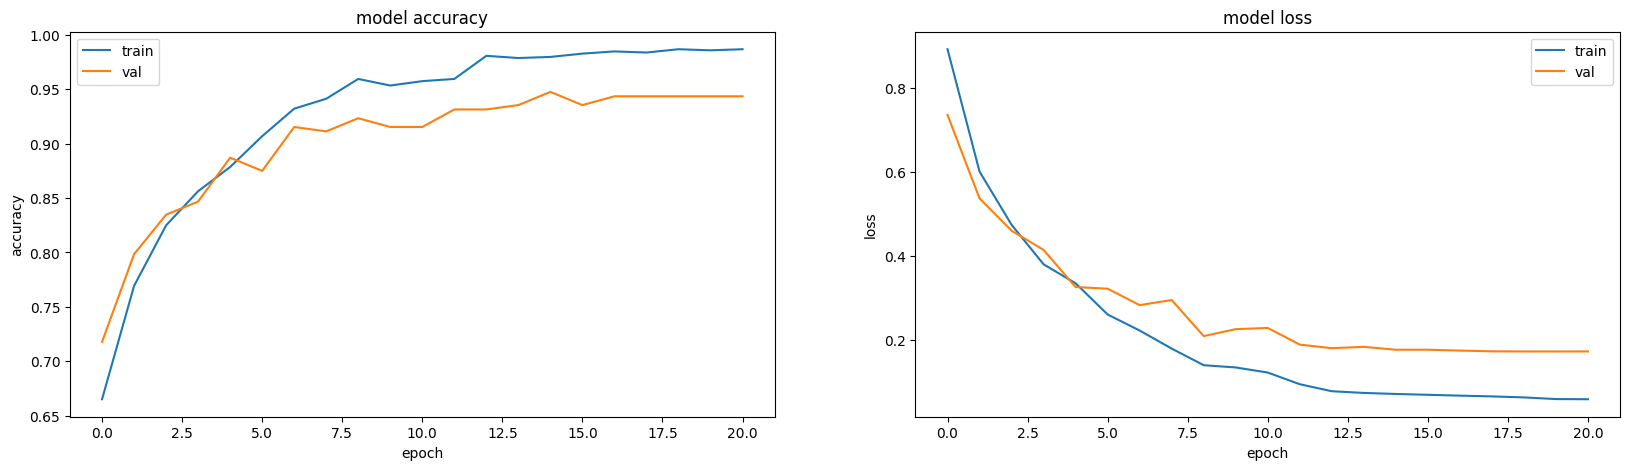

In [832]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [833]:
# Evaluate the model on the test set
test_loss, test_acc = pianoroll_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9485 - loss: 0.1660
Test Loss: 0.1769
Test Accuracy: 0.9476


In [834]:
# Generate predicted probabilities for the test set
y_pred = pianoroll_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       110
           1       0.94      0.94      0.94        50
           2       0.91      0.97      0.94        31
           3       0.93      0.89      0.91        57

    accuracy                           0.95       248
   macro avg       0.94      0.94      0.94       248
weighted avg       0.95      0.95      0.95       248



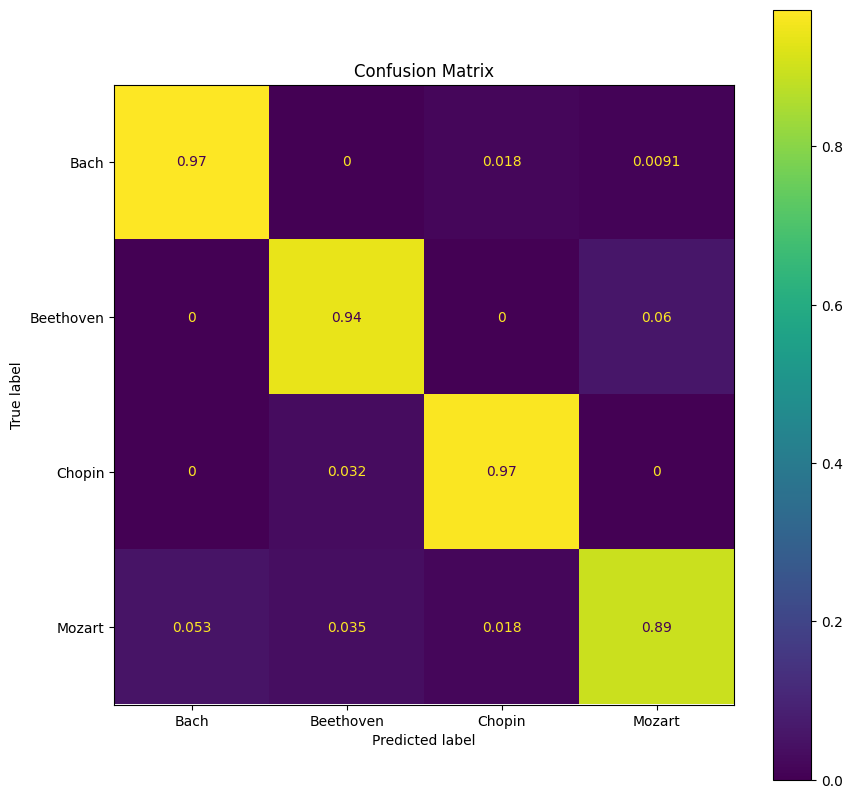

In [835]:
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

### CNN-LSTM: Note sequences model before optimization

In [384]:
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

x = layers.TimeDistributed(layers.Conv2D(32, 2, activation='relu', padding='same'))(seq_input)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

x = layers.LSTM(32)(x)

y = layers.Dense(32, activation='relu')(non_seq_input)
y = layers.Dense(32, activation='relu')(y)

combined = layers.Concatenate()([x, y])

z = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(units = 4, activation ='softmax')(z)

In [385]:
notesequence_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
notesequence_model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_90            │ (None, 41, 256, 3, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_156      │ (None, 41, 256, 3, 32) │            160 │ input_layer_90[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_157      │ (None, 41, 128, 2, 32) │              0 │ time_distributed_156[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_91            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_158      │ (None, 41, 8192)       │              0 │ time_distributed_157[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_202 (Dense)         │ (None, 32)             │            448 │ input_layer_91[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_44 (LSTM)            │ (None, 32)             │      1,052,800 │ time_distributed_158[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_203 (Dense)         │ (None, 32)             │          1,056 │ dense_202[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_44            │ (None, 64)             │              0 │ lstm_44[0][0],         │
│ (Concatenate)             │                        │                │ dense_203[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_204 (Dense)         │ (None, 128)            │          8,320 │ concatenate_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_205 (Dense)         │ (None, 4)              │            516 │ dense_204[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,063,300 (4.06 MB)

 Trainable params: 1,063,300 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [386]:
notesequence_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [387]:
# Create an early stopping callback to stop training the model once loss plataues
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=True
)

# Create a callback to reduce the learning rate by a factor of 0.1 if validation
# accuracy does not approve for more than 2 epochs
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=0.05
)

# Train the model
history = notesequence_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  batch_size=32,
  epochs=30,
  callbacks=[es_callback, lr_callback]
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5021 - loss: 1.1487 - val_accuracy: 0.6976 - val_loss: 0.8567 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6706 - loss: 0.8381 - val_accuracy: 0.7258 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7475 - loss: 0.6550 - val_accuracy: 0.7460 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7513 - loss: 0.6035 - val_accuracy: 0.7702 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7957 - loss: 0.5191 - val_accuracy: 0.7823 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8192 - loss: 0.4653 - val_accuracy: 0.7782 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8123 - loss: 0.4526 - val_ac

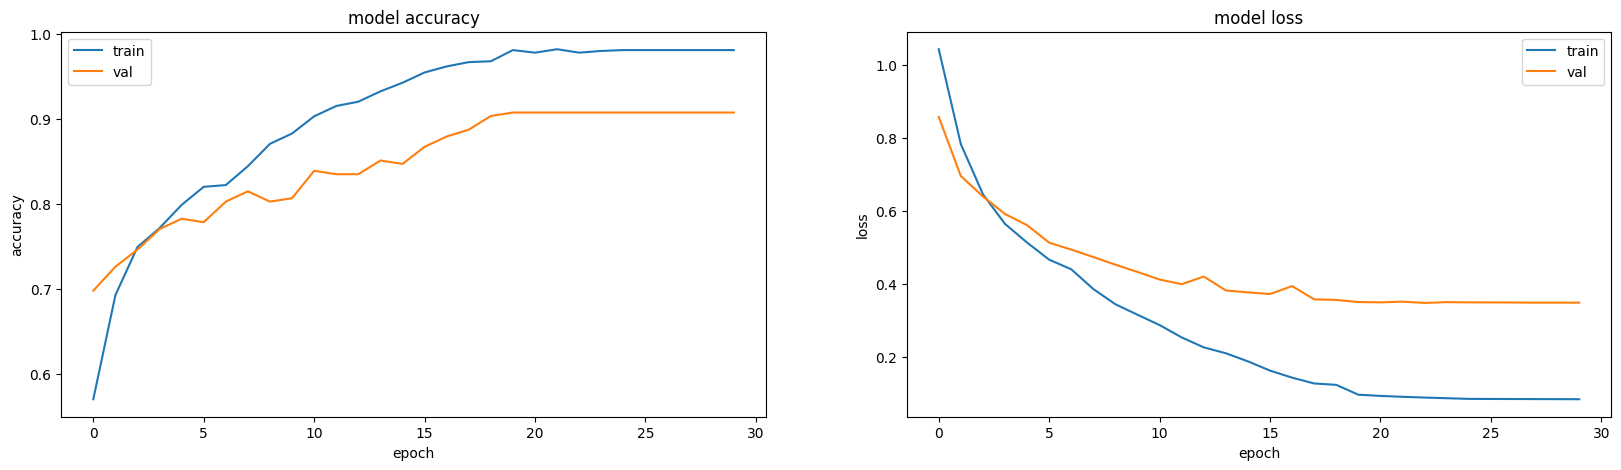

In [388]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [389]:
# Evaluate the model on the test set
test_loss, test_acc = notesequence_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8738 - loss: 0.4494
Test Loss: 0.3477
Test Accuracy: 0.9073


In [390]:
# Generate predicted probabilities for the test set
y_pred = notesequence_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


In [40]:
print(label_encoder.classes_)

['Bach' 'Beethoven' 'Chopin' 'Mozart']


In [391]:
report = classification_report(targets, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       110
           1       0.89      0.86      0.88        49
           2       0.81      0.97      0.88        31
           3       0.85      0.88      0.86        58

    accuracy                           0.91       248
   macro avg       0.88      0.91      0.89       248
weighted avg       0.91      0.91      0.91       248



              precision    recall  f1-score   support

           0       0.98      0.93      0.95       110
           1       0.89      0.86      0.88        49
           2       0.81      0.97      0.88        31
           3       0.85      0.88      0.86        58

    accuracy                           0.91       248
   macro avg       0.88      0.91      0.89       248
weighted avg       0.91      0.91      0.91       248



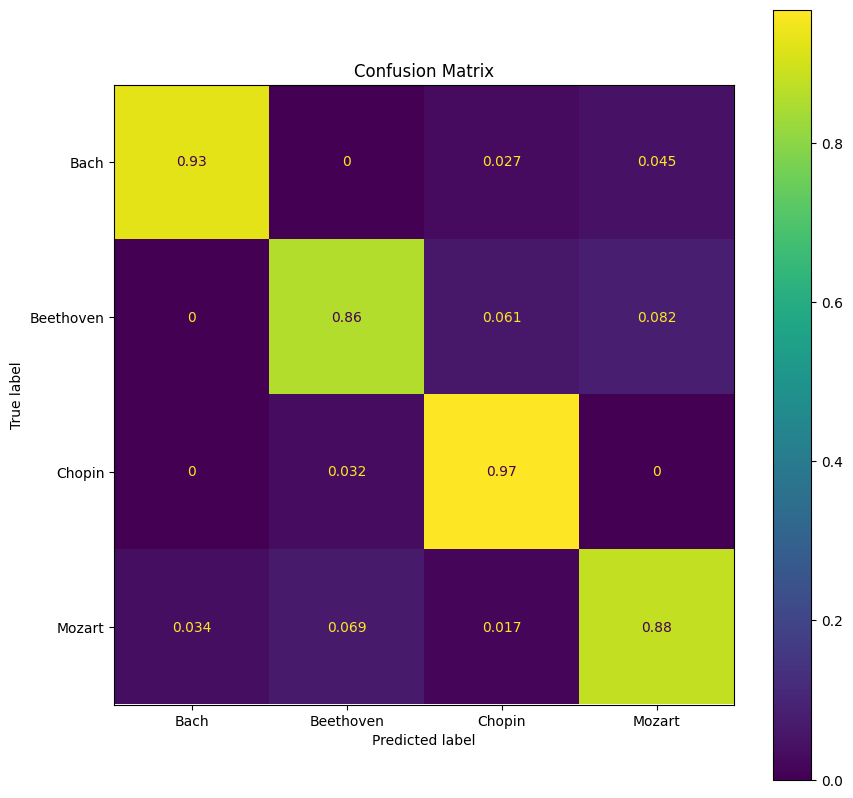

In [392]:
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

### CNN-LSTM: Note sequence model after optimization

In [647]:
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

x = layers.TimeDistributed(layers.Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)))(seq_input)
x = layers.TimeDistributed(layers.Dropout(0.4))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

x = layers.LSTM(16)(x)

y = layers.Dense(64, activation='relu')(non_seq_input)
y = layers.Dense(32, activation='relu')(y)
y = layers.Dense(8, activation='relu')(y)

combined = layers.Concatenate()([x, y])

z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(64, activation='relu')(z)
output = layers.Dense(units = 4, activation ='softmax')(z)

In [648]:
notesequence_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
notesequence_model.summary()

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_156           │ (None, 41, 256, 3, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_288      │ (None, 41, 256, 3, 16) │            160 │ input_layer_156[0][0]  │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_289      │ (None, 41, 256, 3, 16) │              0 │ time_distributed_288[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_157           │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_290      │ (None, 41, 128, 2, 16) │              0 │ time_distributed_289[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_382 (Dense)         │ (None, 64)             │            896 │ input_layer_157[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_291      │ (None, 41, 4096)       │              0 │ time_distributed_290[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_383 (Dense)         │ (None, 32)             │          2,080 │ dense_382[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_77 (LSTM)            │ (None, 16)             │        263,232 │ time_distributed_291[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_384 (Dense)         │ (None, 8)              │            264 │ dense_383[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_77            │ (None, 24)             │              0 │ lstm_77[0][0],         │
│ (Concatenate)             │                        │                │ dense_384[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_385 (Dense)         │ (None, 64)             │          1,600 │ concatenate_77[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_386 (Dense)         │ (None, 64)             │          4,160 │ dense_385[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_387 (Dense)         │ (None, 4)              │            260 │ dense_386[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 272,652 (1.04 MB)

 Trainable params: 272,652 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [649]:
notesequence_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [650]:
# Create an early stopping callback to stop training the model once loss plataues
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=True
)

# Create a callback to reduce the learning rate by a factor of 0.1 if validation
# accuracy does not approve for more than 2 epochs
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=6,
    min_delta=0.05
)

# Train the model
history = notesequence_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  batch_size=8,
  epochs=30,
  callbacks=[es_callback, lr_callback]
)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5162 - loss: 1.1293 - val_accuracy: 0.7298 - val_loss: 0.7264 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7130 - loss: 0.6735 - val_accuracy: 0.7419 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7767 - loss: 0.5528 - val_accuracy: 0.7863 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8231 - loss: 0.4371 - val_accuracy: 0.8347 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8541 - loss: 0.3695 - val_accuracy: 0.8145 - val_loss: 0.4945 - learning_rate: 0.0010
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8463 - loss: 0.3539 - val_accuracy: 0.8105 - val_loss: 0.4746 - learning_rate: 0.0010
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8709 - loss: 0

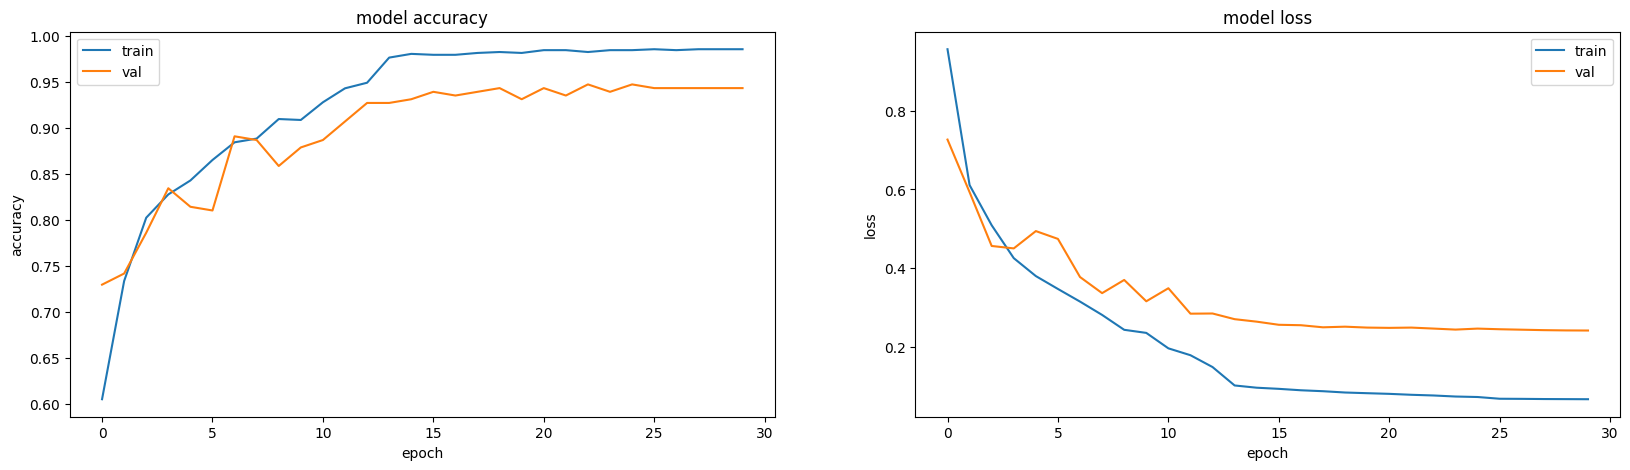

In [651]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [652]:
# Evaluate the model on the test set
test_loss, test_acc = notesequence_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9358 - loss: 0.3019
Test Loss: 0.2474
Test Accuracy: 0.9476


In [653]:
# Generate predicted probabilities for the test set
y_pred = notesequence_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       110
           1       0.94      0.98      0.96        49
           2       0.91      0.94      0.92        31
           3       0.95      0.91      0.93        58

    accuracy                           0.95       248
   macro avg       0.94      0.95      0.94       248
weighted avg       0.95      0.95      0.95       248



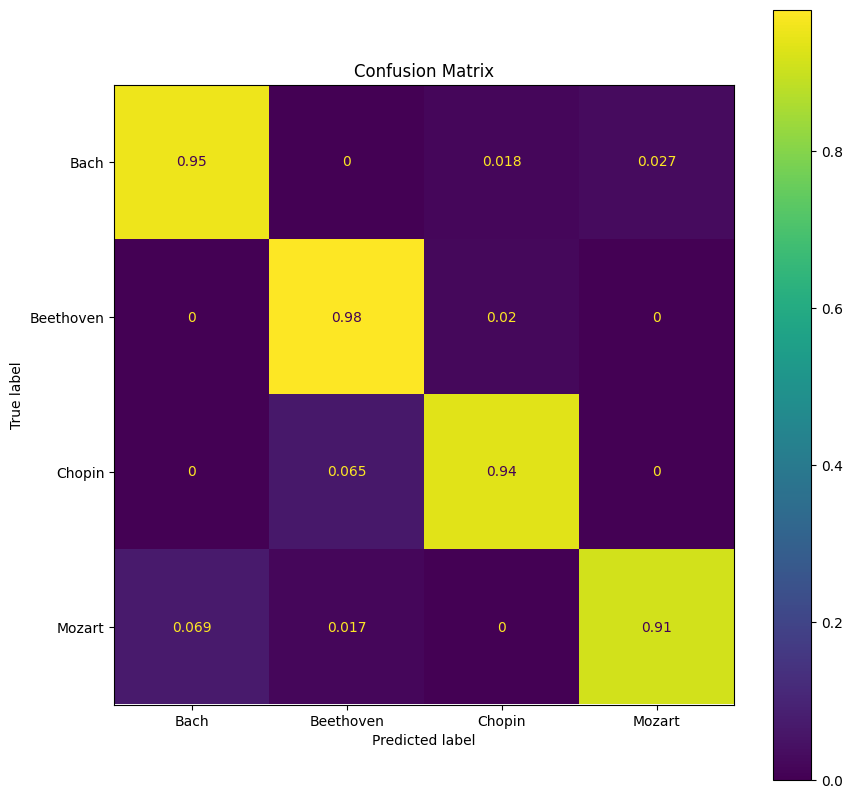

In [654]:
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

## Conclusion

Summary